In [1]:
# install from requirements.txt
!pip install -r ../requirements.txt

  Using cached altair-5.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached pyarrow-18.1.0.tar.gz (1.1 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
  Using cached tenacity-9.0.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl.metadata (13 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached narwhals-1.15.0-py3-none-any.whl.metadata (8.1 kB)
  Using cached gitdb-4.0.11-py3-none-any.whl.metadata (1.2 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached smmap-5.0.1-py3-none-any.whl.metadata (4.3 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
Using cached altair-5.5.0-py3-none-any.whl (73

# Data quality Assessment tool

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk

import re
import requests

import warnings
warnings.filterwarnings('ignore')

## Get the data
Get the data from the google sheets

In [3]:
base_url : str = 'https://docs.google.com/spreadsheets/d/173kXrmgG0K4Q_K0d2GFgADnW3wB66xh9R1IdyjB3eXY/edit?gid=1#gid=1'

In [4]:
def is_valid_url(url: str) -> bool:
    """Checks if the URL is valid."""
    return bool(re.match(r'https?://[^\s/$.?#].[^\s]*', url))

def ensure_schema(url: str) -> str:
    """Ensures the URL has a valid schema."""
    return url if url.startswith(('http://', 'https://')) else 'https://' + url

def convert_spreadsheet_to_csv(spreadsheet_url: str) -> str:
    """Converts a Google spreadsheet URL to a CSV export URL."""
    return re.sub(r'/edit.*$', '/export?format=csv', spreadsheet_url)

def convert_airtable_to_url(airtable_url: str) -> str:
    """Converts an Airtable URL to the original Google sheet URL."""
    return re.sub(r'/tbl([^/]+)/([^/]+)', r'/tbl\1/\2/csv', airtable_url)

def convert_url(url: str) -> str:
    """Converts various shortened URLs to their original form."""
    try:
        return requests.get(url, verify=False, allow_redirects=True).url
    except requests.exceptions.RequestException as e:
        print(f"Failed to convert URL: {e}")
        return url

from urllib.error import HTTPError

def get_the_data(sheet_url: str, visited: set = None, max_depth: int = 3, current_depth: int = 0) -> pd.DataFrame: # type: ignore
    """Retrieves data from a Google sheet and returns it as a pandas DataFrame."""
    if visited is None:
        visited = set()

    if not sheet_url or not is_valid_url(sheet_url):
        print(f"Invalid URL: {sheet_url}")
        return pd.DataFrame()

    # Prevent infinite loops by checking if the sheet has already been visited
    if sheet_url in visited:
        print(f"Already visited: {sheet_url}")
        return pd.DataFrame()

    visited.add(sheet_url)

    csv_export_url = convert_spreadsheet_to_csv(sheet_url)

    try:
        data = pd.read_csv(csv_export_url)

        # Check if the column has an entry 'See next sheet'
        if 'Unnamed: 1' in data.columns and data.shape[0] == 1:
            if current_depth < max_depth:
                next_sheet = 'https://docs.google.com/spreadsheets/d/1OvDq4_BtbR6nSnnHnjD5hVC3HQ-ulZPGbo0RDGbzM3Q/edit?usp=sharing'
                print(f"Found 'See next sheet' in {sheet_url} \n\t- fetching next sheet: {next_sheet}")
                return get_the_data(next_sheet, visited, max_depth, current_depth + 1)
            else:
                print(f"Max depth reached for {sheet_url}. Stopping recursion.")
                return data

        return data
    except HTTPError as e:
        # print(f"HTTP error occurred: {e}")
        return pd.DataFrame()
    except Exception as e:
        # print(f"An error occurred: {e}")
        return pd.DataFrame()

def get_datasets(base_df: pd.DataFrame, target_column: str = 'bitly ') -> list:
    """Retrieves datasets from the specified column in the DataFrame."""
    datasets = []
    conversion_functions = {
        'spreadsheets': convert_spreadsheet_to_csv,
        'bit.ly': convert_url,
        'airtable.com': convert_airtable_to_url,
        'geni': convert_url,
    }

    for _, row in base_df.iterrows():
        entry = ensure_schema(row[target_column].strip())
        title = row['title']

        for keyword, func in conversion_functions.items():
            if keyword in entry:
                entry = func(entry)
                break

        if 'informationisbeautiful' in entry:
            continue

        dataset = get_the_data(entry)
        if not dataset.empty:
            datasets.append({'entry': dataset, 'title': title})

    return datasets

# Example usage
dataset_base = get_the_data(base_url)
multi_datasets = get_datasets(dataset_base)


Found 'See next sheet' in https://docs.google.com/spreadsheets/d/1OvDq4_BtbR6nSnnHnjD5hVC3HQ-ulZPGbo0RDGbzM3Q/edit#gid=1 
	- fetching next sheet: https://docs.google.com/spreadsheets/d/1OvDq4_BtbR6nSnnHnjD5hVC3HQ-ulZPGbo0RDGbzM3Q/edit?usp=sharing
Found 'See next sheet' in https://docs.google.com/spreadsheets/d/1OvDq4_BtbR6nSnnHnjD5hVC3HQ-ulZPGbo0RDGbzM3Q/edit?usp=sharing 
	- fetching next sheet: https://docs.google.com/spreadsheets/d/1OvDq4_BtbR6nSnnHnjD5hVC3HQ-ulZPGbo0RDGbzM3Q/edit?usp=sharing
Already visited: https://docs.google.com/spreadsheets/d/1OvDq4_BtbR6nSnnHnjD5hVC3HQ-ulZPGbo0RDGbzM3Q/edit?usp=sharing


In [5]:
def clean_data(data:pd.DataFrame) -> pd.DataFrame:
    """ Cleans the data by checking if the first value is a number then converting the column to numeric """
    for column in data.columns:
        # check if the first value is not a letter
        first_entry = str(data[column].iloc[0])

        if not isinstance(first_entry, str) or not first_entry.isalpha():
            # print(f"First entry '{first_entry}' is not all letters. Converting column '{column}' to float.")
            # Convert the column to float
            data[column] = pd.to_numeric(data[column], errors='coerce')
        else:
            continue
    print(f'Types: {data.dtypes}')
    return data

for dataset in multi_datasets:
    dataset['entry'] = clean_data(dataset['entry'])

Types: COUNTRY (lowest estimate or overall estimate used)                                                                 object
Cocaine, % of pop adults                                                                                          float64
Cannabis, % of pop, adults                                                                                        float64
Amphetamines, % of pop, adults                                                                                     object
Opiates, % of pop, adults                                                                                         float64
happiness rating (2006)                                                                                           float64
total drug use                                                                                                    float64
alcohol use per capita                                                                                             object
sources: guardian

In [6]:
for dataset in multi_datasets:
    display(f"Title: {dataset['title']}")
    display(f"Shape: {dataset['entry'].shape}")
    display(f"Columns: {dataset['entry'].columns.tolist()}")
    display(dataset['entry'].head(2))
    break

'Title: Can Drugs Make You Happy?'

'Shape: (194, 10)'

"Columns: ['COUNTRY (lowest estimate or overall estimate used)', 'Cocaine, % of pop adults', 'Cannabis, % of pop, adults ', 'Amphetamines, % of pop, adults ', 'Opiates, % of pop, adults ', 'happiness rating (2006)', 'total drug use', 'alcohol use per capita', 'sources: guardian.co.uk, World Database of Happiness', 'http://www.guardian.co.uk/news/datablog/2009/jun/24/drugs-trade-drugs, http://worlddatabaseofhappiness.eur.nl/']"

COUNTRY (lowest estimate or overall estimate used)  \
0                                        Afghanistan   
1                                            Albania   

   Cocaine, % of pop adults  Cannabis, % of pop, adults   \
0                       NaN                          3.6   
1                       0.1                          1.8   

  Amphetamines, % of pop, adults   Opiates, % of pop, adults   \
0                             NaN                         NaN   
1                             0.1                        0.45   

   happiness rating (2006)  total drug use alcohol use per capita  \
0                      4.7            3.60                    NaN   
1                      4.6            2.45                   2.51   

  sources: guardian.co.uk, World Database of Happiness  \
0                                                NaN     
1                                                NaN     

   http://www.guardian.co.uk/news/datablog/2009/jun/24/drugs-trade-drugs, http://worlddatabaseofhappiness.eur.nl/  
0                                                NaN                                                               
1                                                NaN

## Data Quality Checks

### Identify missing values
Deal with NaNs ; replace NaN with the median/mean/mode


In [7]:
def identify_missing_values(data: pd.DataFrame) -> pd.DataFrame:
    """Identify NaNs and replace numeric NaNs with median and categorical NaNs with mode."""
    # Count NaNs before replacement
    # missing_before = data.isna().sum().sum()
    # print(f"Before: {missing_before}", end='\t') DEBUGGING

    # Replace NaNs in numeric columns with median+
    numerical_columns = data.select_dtypes(include=[np.number]).columns
    data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].median())

    # Replace NaNs in categorical columns with mode
    categorical_columns = data.select_dtypes(include=['object']).columns
    data[categorical_columns] = data[categorical_columns].apply(lambda col: col.fillna(col.mode()[0]) if not col.mode().empty else col)

    # if missing values are more than 80% of the dataset, drop the column
    missing_threshold = 0.8
    data = data.dropna(thresh=int(missing_threshold*data.shape[0]), axis=1)
    
    # Count NaNs after replacement
    missing_after = data.isna().sum().sum()
    if missing_after > 0:
        display(data[data.isna().any(axis=1)]) 
        print(f"After: {missing_after}", end='\n\n') ##DEBUGGING

    return data

for idx, dataset in enumerate(multi_datasets):
    """ Replace NaNs in each dataset """
    print(f"Dataset {idx}: {dataset['title']}", end='\n')
    dataset['entry'] = identify_missing_values(dataset['entry'])

Dataset 0: Can Drugs Make You Happy?
Dataset 1: Reduce Your Odds Of Dying In A Plane Crash
Dataset 2: How I Learned To Stop Worrying And Love The Bomb
Dataset 3: Afghanistan Troop Casualties
Dataset 4: Caffeine and Calories
Dataset 5: Billion Dollar-o-Gram
Dataset 6: Timelines: Time Travel In Popular Film And TV
Dataset 7: Swine Flu Visualised
Dataset 8: Fatal Infection
Dataset 9: Kyoto: Who's On Target
Dataset 10: Who Rules The Social Web
Dataset 11: 2012: The End Of The World?
Dataset 12: Afghanistan: The Information Is Not Beautiful
Dataset 13: Climate Change: A Consensus Among Scientists?
Dataset 14: What Does China Censor Online
Dataset 15: Haiti Earthquake: Who's Given What?
Dataset 16: When Sea Levels Attack
Dataset 17: Snake-Oil 2
Dataset 18: The BBC-o-Gram


http://www.bbc.co.uk/annualreport/2013/home/
0                                           NaN

After: 1

Dataset 19: How Much Do Music Artists Earn Online
Dataset 20: Plane Or Volcano?
Dataset 21: Colours In Cultures
Dataset 22: UK Political Parties: Do They Cut It?
Dataset 23: International Number Ones
Dataset 24: In Deep Water: Can We Afford To Spill Any Oil
Dataset 25: Poll Dancing: How Accurate Are Opinion Polls
Dataset 26: Because Every Country Is Best At Something
Dataset 27: In Deeper Water
Dataset 28: The Billion Dollar-o-Gram 2009
Dataset 29: Wikipedia's Lamest Edit Wars
Dataset 30: The UK Tax Gap Visualised
Dataset 31: Who's Suing Whom In The Telecoms Trade
Dataset 32: You've Been Quangoed
Dataset 33: Debtris
Dataset 34: How Much Carbon..
Dataset 35: Horoscoped
Dataset 36: Books Everyone Should Read
Dataset 37: Radiation Dosage Chart
Dataset 38: Snake Oil V2.0
Dataset 39: The Sunscreen Smokescreen
Dataset 40: Is The HPV Vaccine Safe?
Dataset 41: What are the Wall St Protestors So Angry About?
Dataset 42: Scales of Devastation
Dataset 43: Hollywood Budgets
Dataset 44: P

### Identify duplicates
Remove duplicate values in the dataset


In [8]:
def remove_duplicates(title:str, data:pd.DataFrame):
    """Remove duplicates in the dataset."""
    # Count duplicates before removal
    duplicates_before = data.duplicated().sum()
    if duplicates_before > 0:
        print(f"{title}\t\t{duplicates_before} before ...") ##DEBUGGING

    # Remove duplicates
    data = data.drop_duplicates()
    return data

for idx, dataset in enumerate(multi_datasets):
    """ Remove duplicates in each dataset """
    dataset['entry'] = remove_duplicates(dataset['title'] ,dataset['entry'])

Afghanistan Troop Casualties		17 before ...
Billion Dollar-o-Gram		4 before ...
Timelines: Time Travel In Popular Film And TV		1 before ...
Who Rules The Social Web		1 before ...
2012: The End Of The World?		81 before ...
Afghanistan: The Information Is Not Beautiful		17 before ...
What Does China Censor Online		230 before ...
Haiti Earthquake: Who's Given What?		7 before ...
When Sea Levels Attack		13 before ...
Snake-Oil 2		3 before ...
Plane Or Volcano?		102 before ...
Colours In Cultures		15 before ...
UK Political Parties: Do They Cut It?		1 before ...
In Deep Water: Can We Afford To Spill Any Oil		6 before ...
Poll Dancing: How Accurate Are Opinion Polls		38 before ...
In Deeper Water		6 before ...
The Billion Dollar-o-Gram 2009		1 before ...
Wikipedia's Lamest Edit Wars		1 before ...
The UK Tax Gap Visualised		15 before ...
Who's Suing Whom In The Telecoms Trade		22 before ...
You've Been Quangoed		1 before ...
Debtris		1 before ...
How Much Carbon..		14 before ...
Books Everyon

### Look at outliers
Use _z-score_ to find outliers or _box (whisker) plots_ to visually identify the data distributions and outliers

In [9]:
from matplotlib.pylab import f
from scipy import stats

def check_for_outliers(data:pd.DataFrame)-> pd.DataFrame:
    """Calculate the z-score for each column in the dataset"""
    
    # display(data.dtypes) ##DEBUGGING
    z_scores = {'Column':[], 'Outliers':[], 'Percentage of Outliers':[]}
    # For each column, calculate the z-score
    for column in data.columns:
        # print(f'Column: {column} dtype: {data[column].dtype}') ##DEBUGGING
        if data[column].dtype == 'object':
            continue
        else:
            column_z_scores = stats.zscore(data[column].to_numpy())
            # Identify outliers higher than 3 standard deviations
            outlier_indices = np.where(np.abs(column_z_scores) > 3)[0]
            # print(f"{column}: {outliers} {data[column].iloc[outliers]}") ##DEBUGGING
            # Get the outliers
            outliers = data[column].iloc[outlier_indices].to_numpy()

            if outliers.size > 0:
                z_scores['Column'].append(column)
                z_scores['Outliers'].append(outliers)
                z_scores['Percentage of Outliers'].append(f"{(outliers.size/data[column].size)*100:.3f}%")
        
    return pd.DataFrame.from_dict(z_scores)

for idx, dataset in enumerate(multi_datasets):
    """ Check for outliers in each dataset """
    outliers = check_for_outliers(dataset['entry'])
    if outliers.empty:
        # print(f"No outliers found in {dataset['title']} dataset.")
        continue
    else:
        print(f"Dataset {idx}: {dataset['title']} with {dataset['entry'].shape[0]} rows", end='\n')
        for _, rows in outliers.iterrows():
            print(f"\t{rows['Column']} has {len(rows['Outliers'])} outliers", end='\n')
        # display(outliers) ##DEBUGGING

# --------- Maximum number of outliers is 27 ------------

Dataset 0: Can Drugs Make You Happy? with 194 rows
	Cocaine, % of pop adults has 6 outliers
	Cannabis, % of pop, adults  has 6 outliers
	Opiates, % of pop, adults  has 4 outliers
	total drug use has 6 outliers
Dataset 2: How I Learned To Stop Worrying And Love The Bomb with 13 rows
	Intercontinental missiles has 1 outliers
	Submarines/ nonstrategic  has 1 outliers
	TOTAL, 2009 has 1 outliers
	TOTAL IN 2000 has 1 outliers
Dataset 3: Afghanistan Troop Casualties with 17 rows
	Unnamed: 1 has 1 outliers
	Unnamed: 2 has 1 outliers
	Unnamed: 3 has 1 outliers
	Unnamed: 4 has 1 outliers
Dataset 4: Caffeine and Calories with 29 rows
	priceMGActual has 1 outliers
	price has 1 outliers
Dataset 5: Billion Dollar-o-Gram with 45 rows
	billion dollars has 1 outliers
Dataset 6: Timelines: Time Travel In Popular Film And TV with 52 rows
	From has 1 outliers
	To has 1 outliers
Dataset 7: Swine Flu Visualised with 124 rows
	Lab confirmed cases has 4 outliers
	deaths has 2 outliers
	stories about swine fl

## Feature Analysis

### Evaluate feature importance
Evaluate feature importance by looking at the distributions to look at relationships

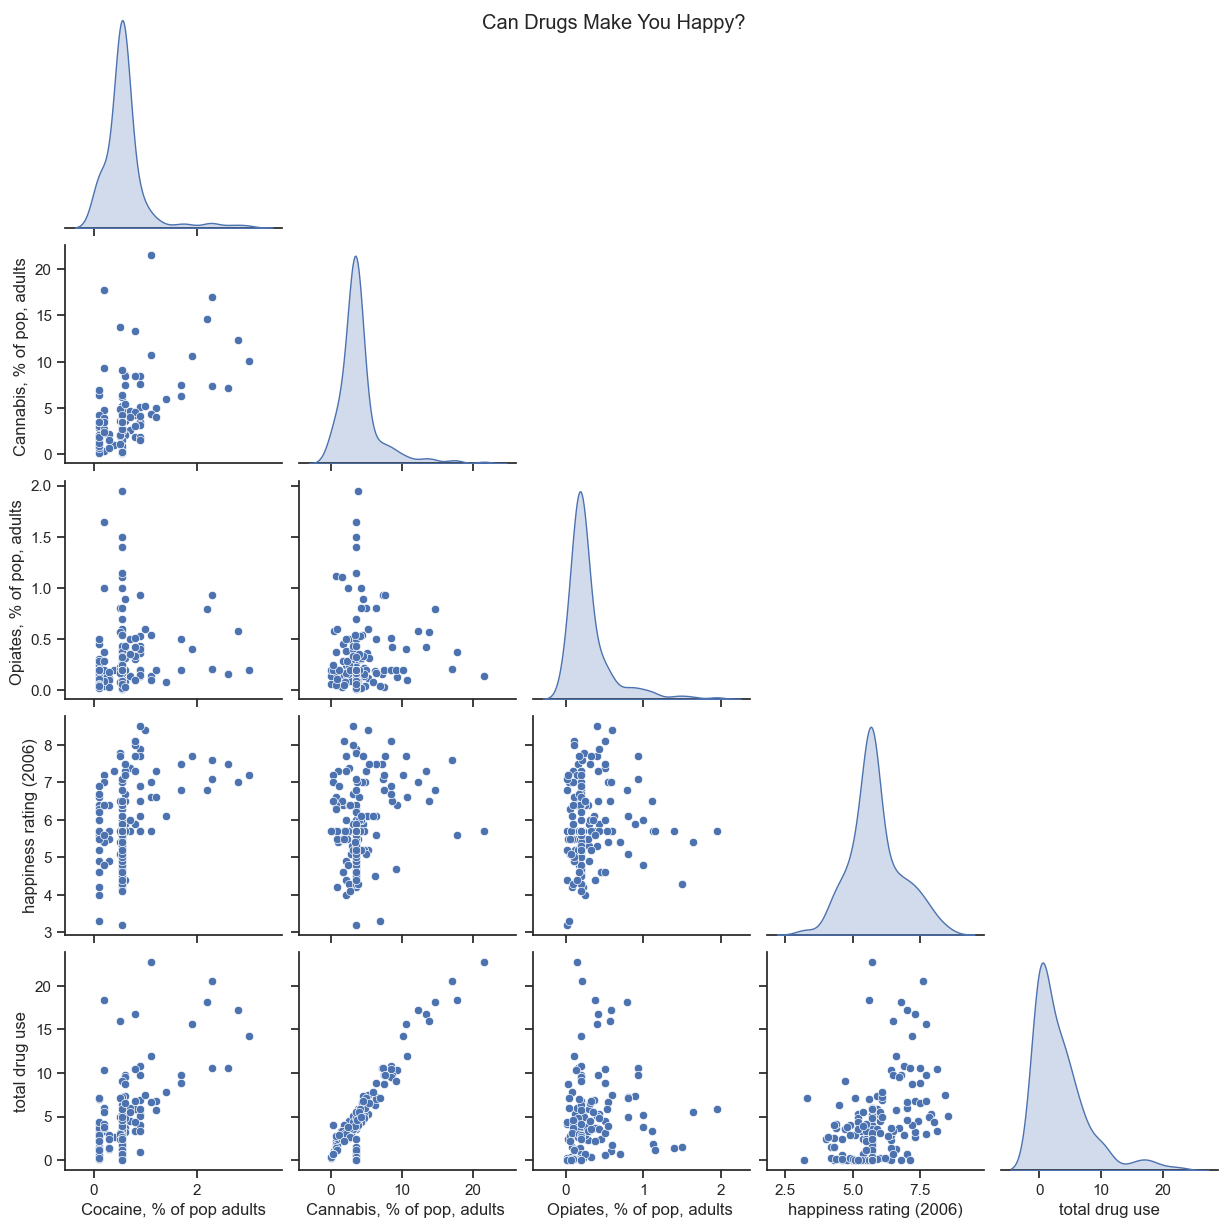

Not enough columns/rows to plot for dataset: Reduce Your Odds Of Dying In A Plane Crash
Not enough columns/rows to plot for dataset: How I Learned To Stop Worrying And Love The Bomb
Not enough columns/rows to plot for dataset: Afghanistan Troop Casualties


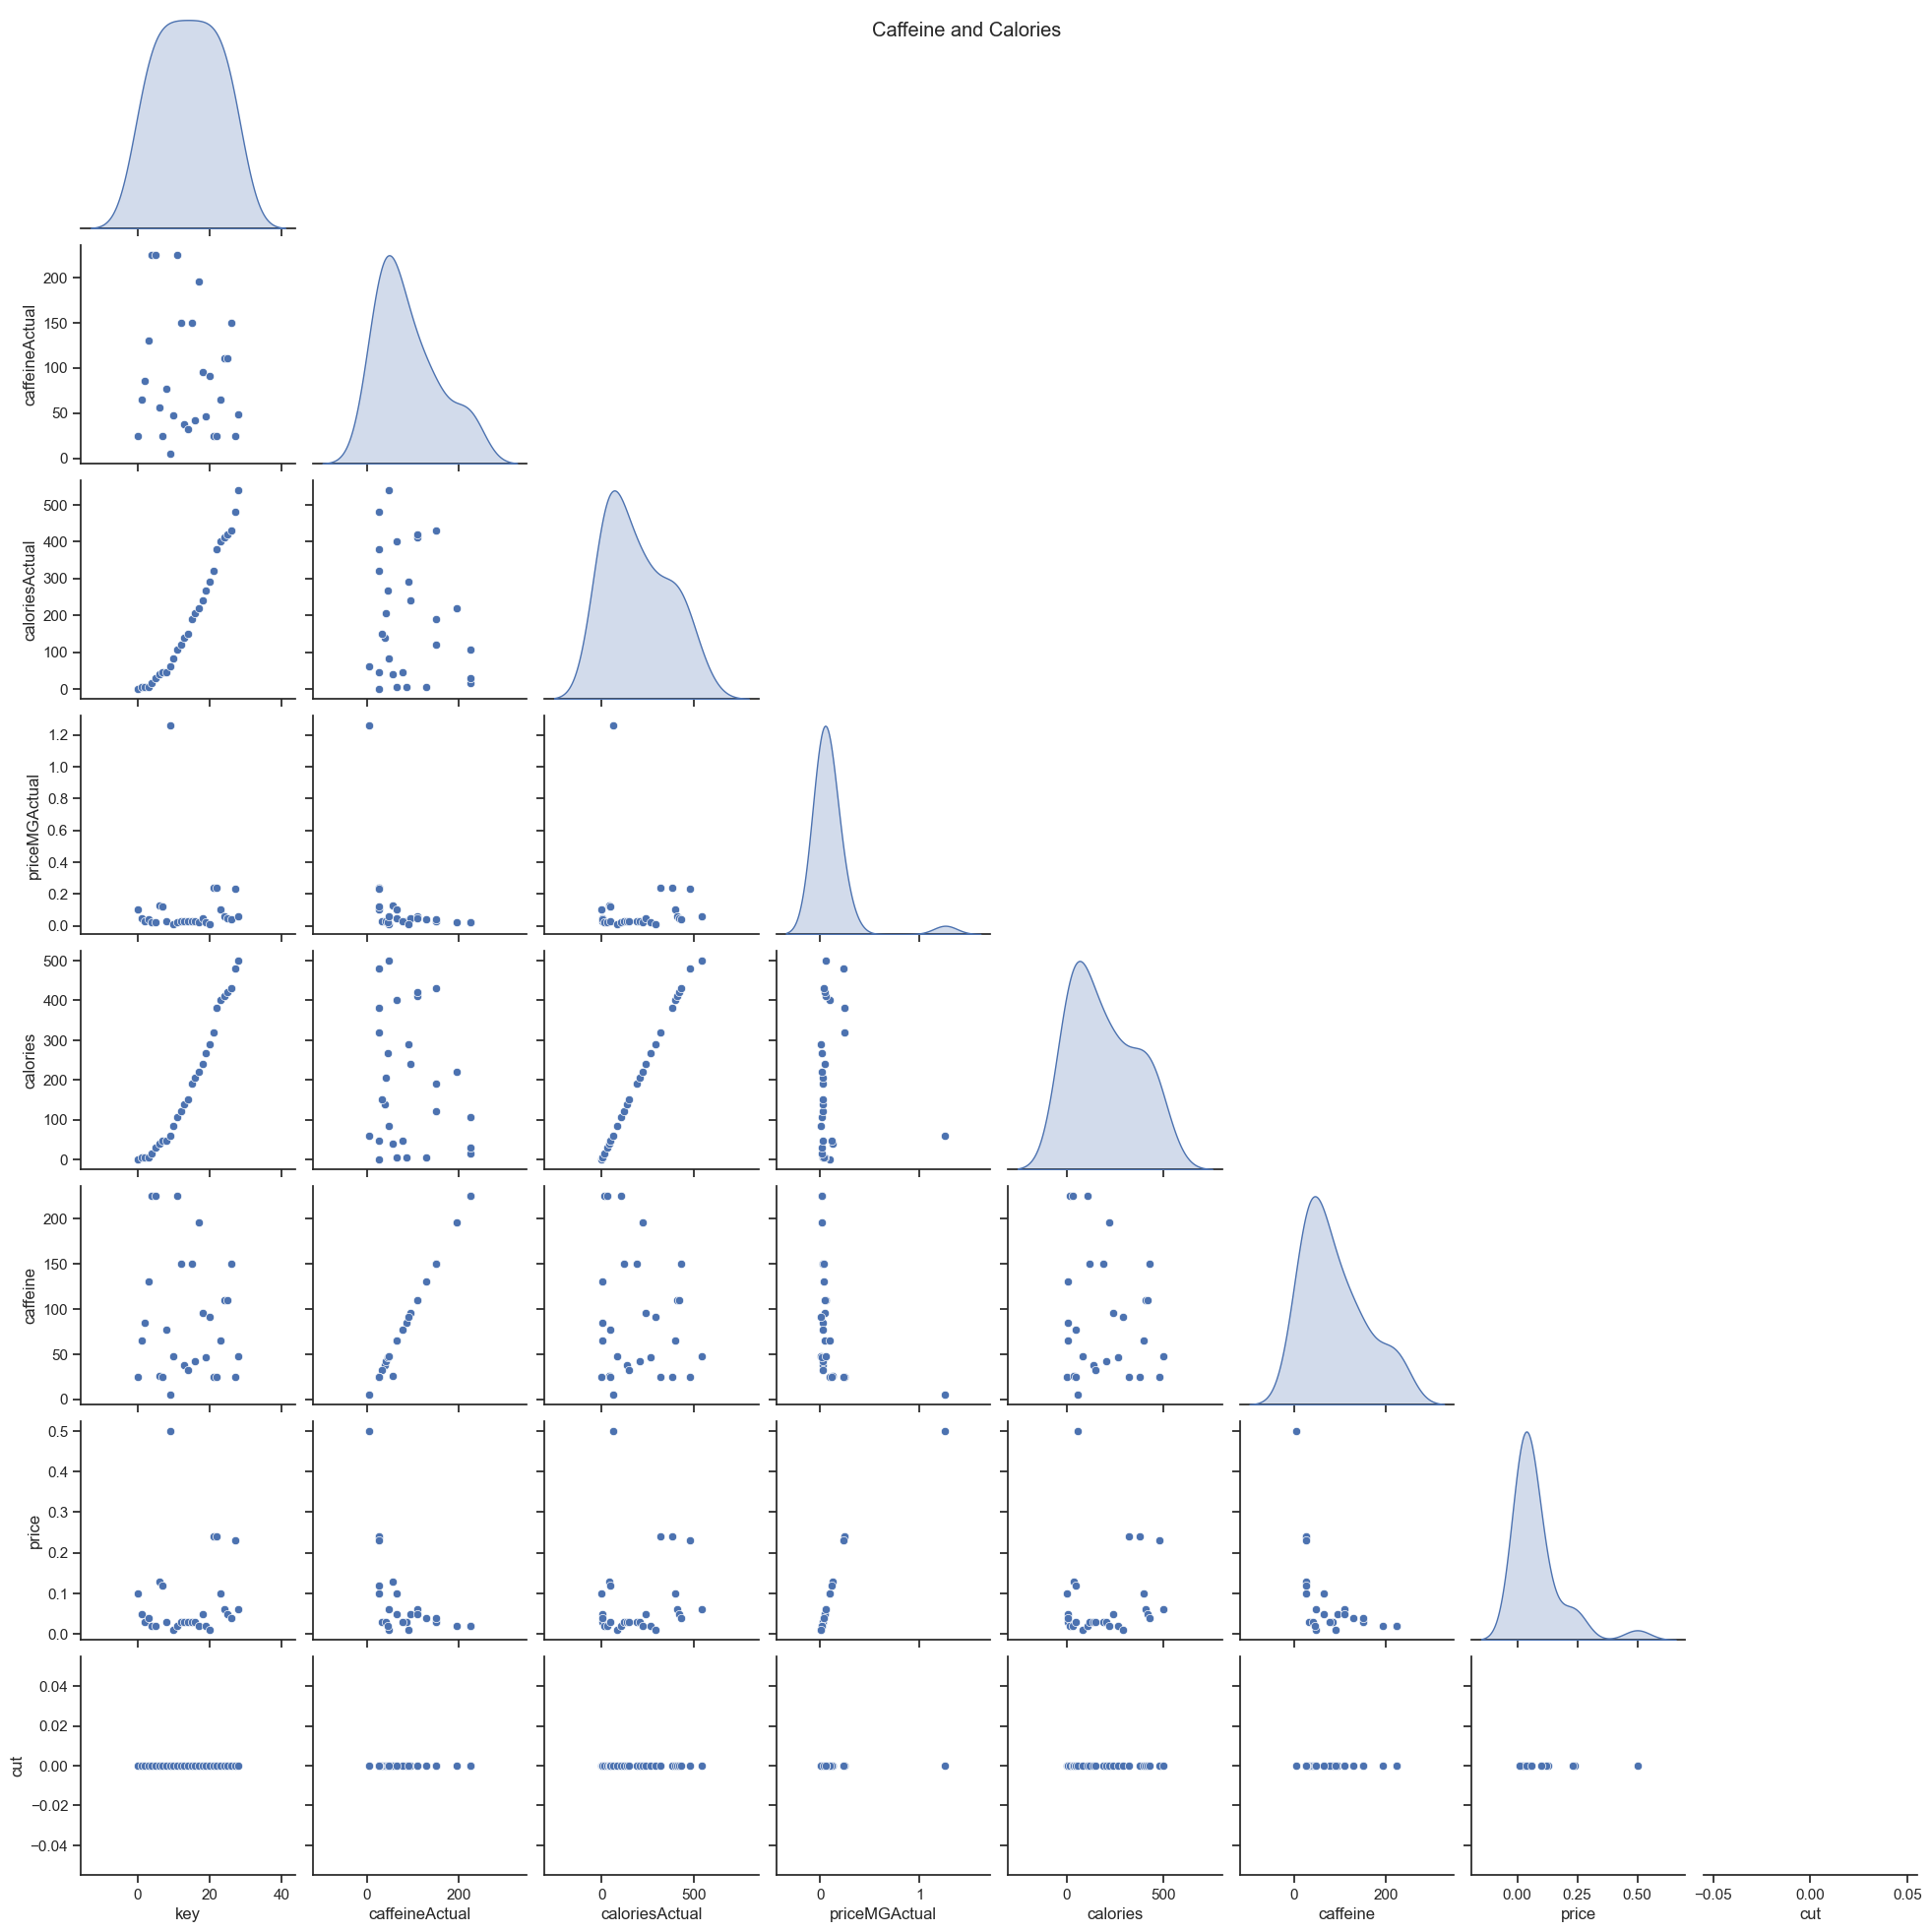

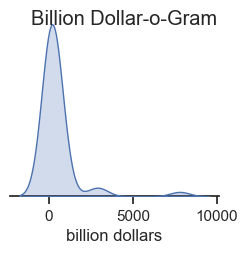

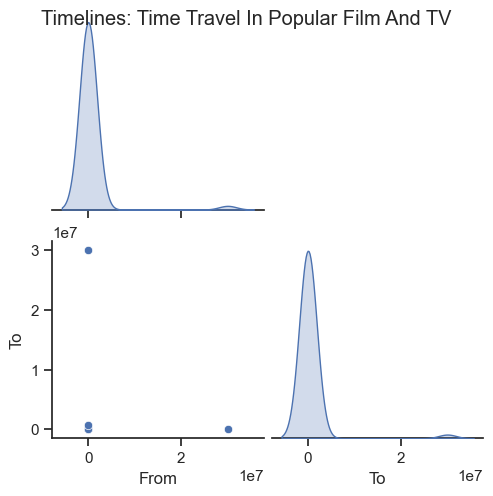

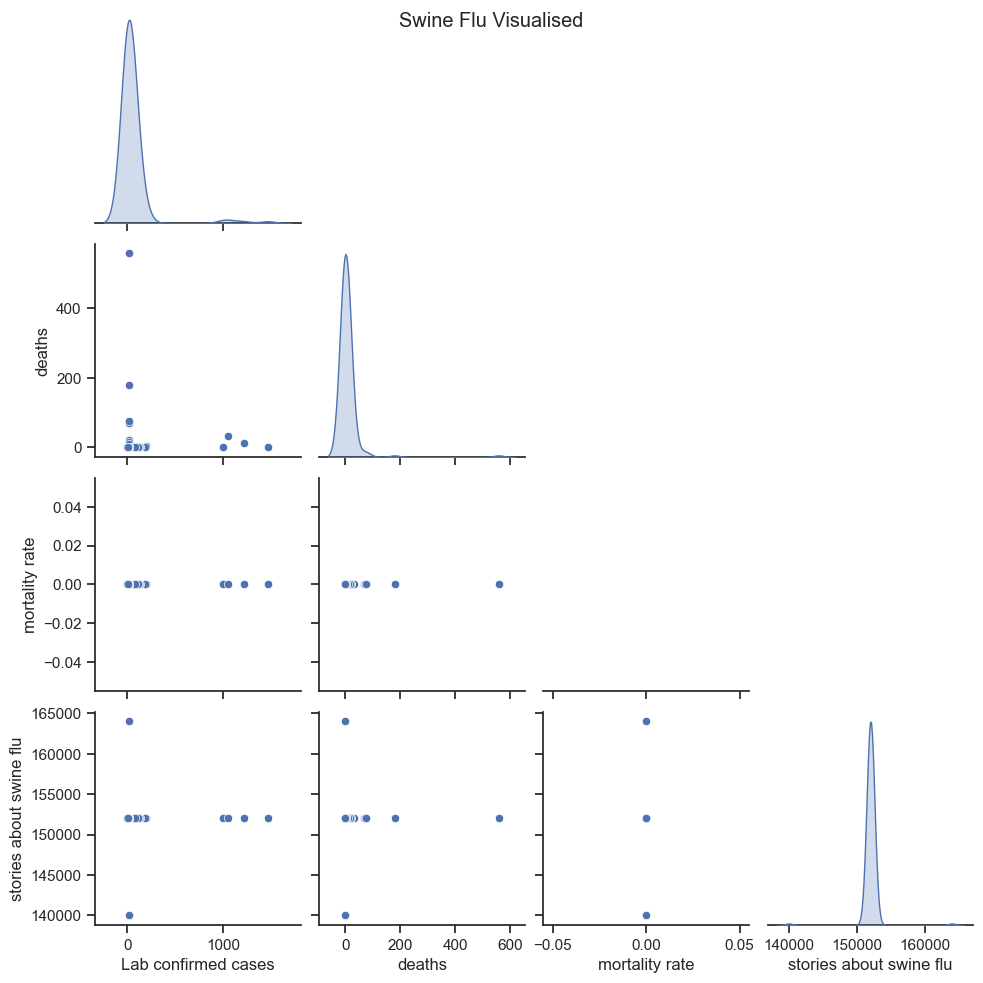

Fatal Infection error occurred: No variables found for grid columns.
Kyoto: Who's On Target error occurred: No variables found for grid columns.


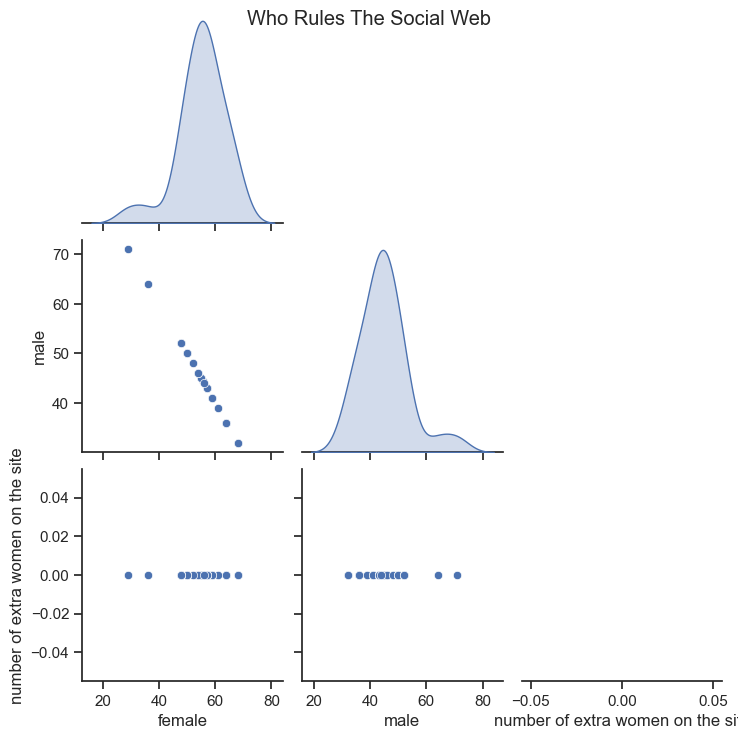

Not enough columns/rows to plot for dataset: 2012: The End Of The World?
Not enough columns/rows to plot for dataset: Afghanistan: The Information Is Not Beautiful
Not enough columns/rows to plot for dataset: Climate Change: A Consensus Among Scientists?
Not enough columns/rows to plot for dataset: What Does China Censor Online


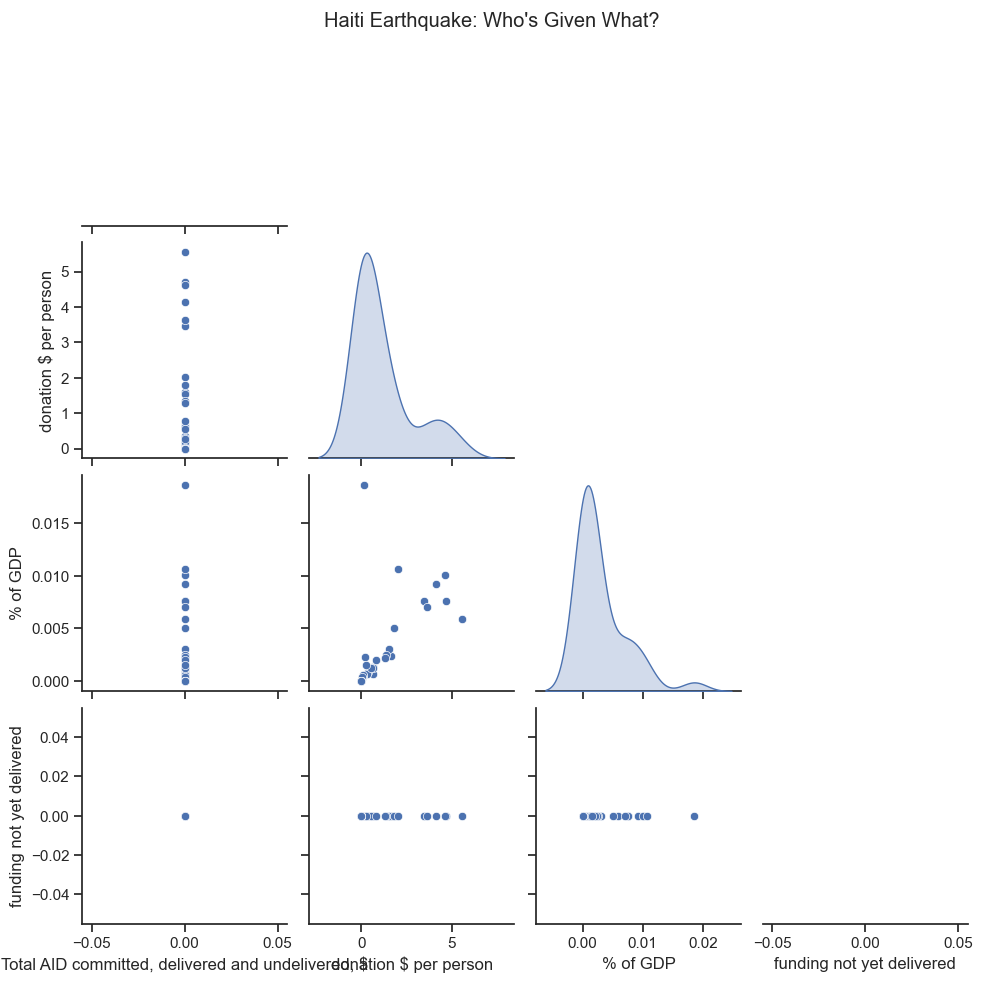

When Sea Levels Attack error occurred: No variables found for grid columns.


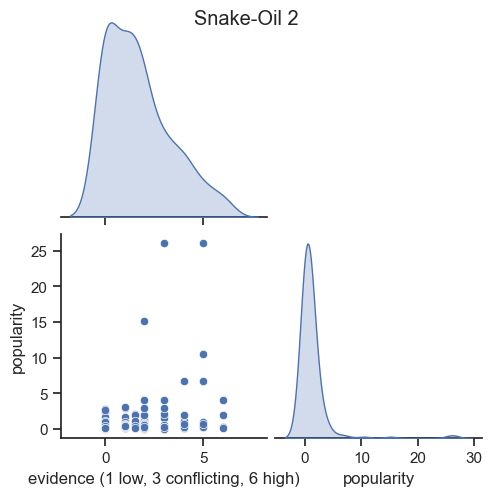

Not enough columns/rows to plot for dataset: The BBC-o-Gram
Not enough columns/rows to plot for dataset: How Much Do Music Artists Earn Online
Not enough columns/rows to plot for dataset: Plane Or Volcano?
Colours In Cultures error occurred: No variables found for grid columns.


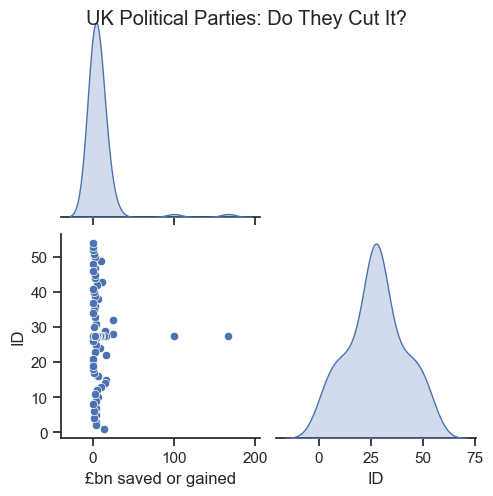

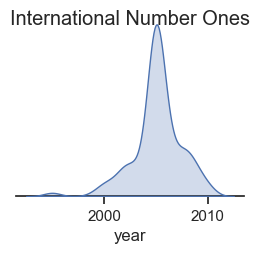

Not enough columns/rows to plot for dataset: In Deep Water: Can We Afford To Spill Any Oil


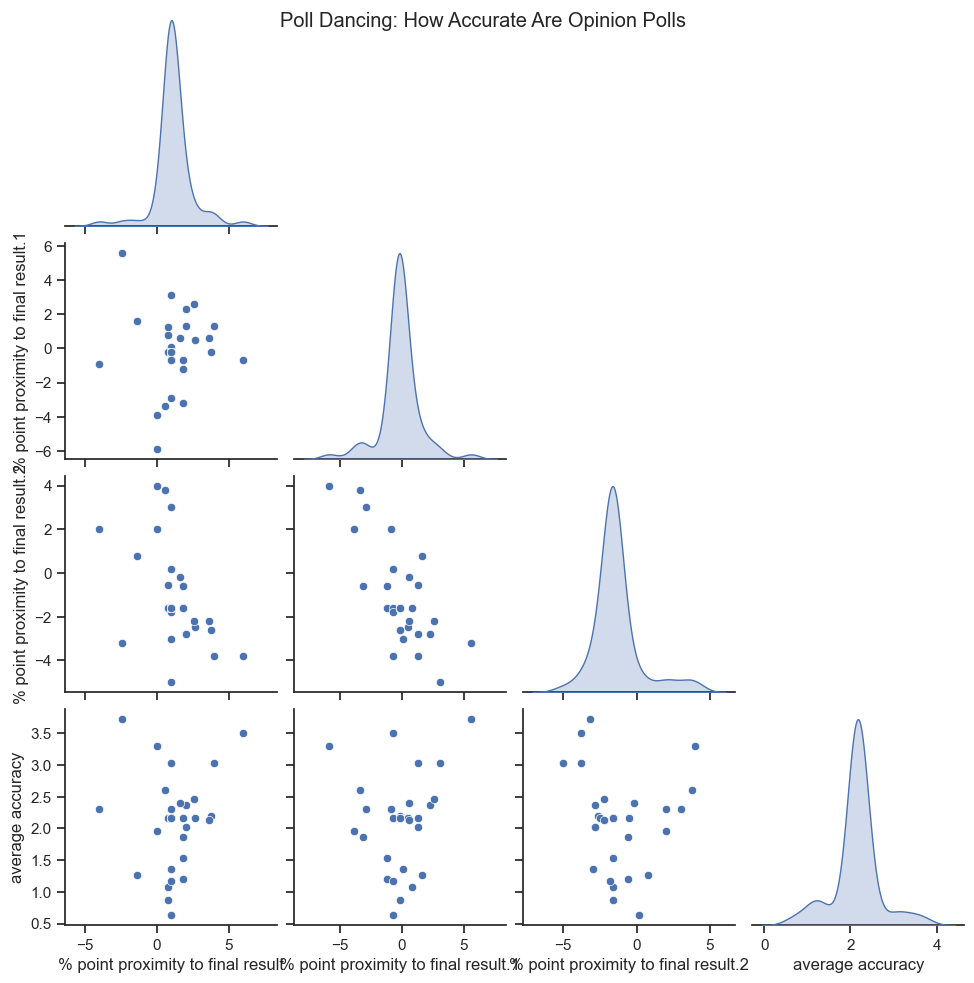

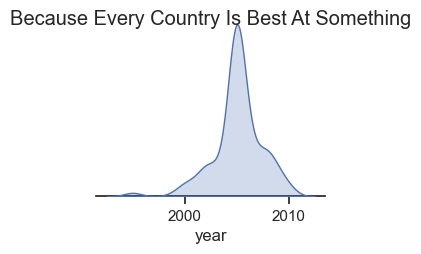

Not enough columns/rows to plot for dataset: In Deeper Water


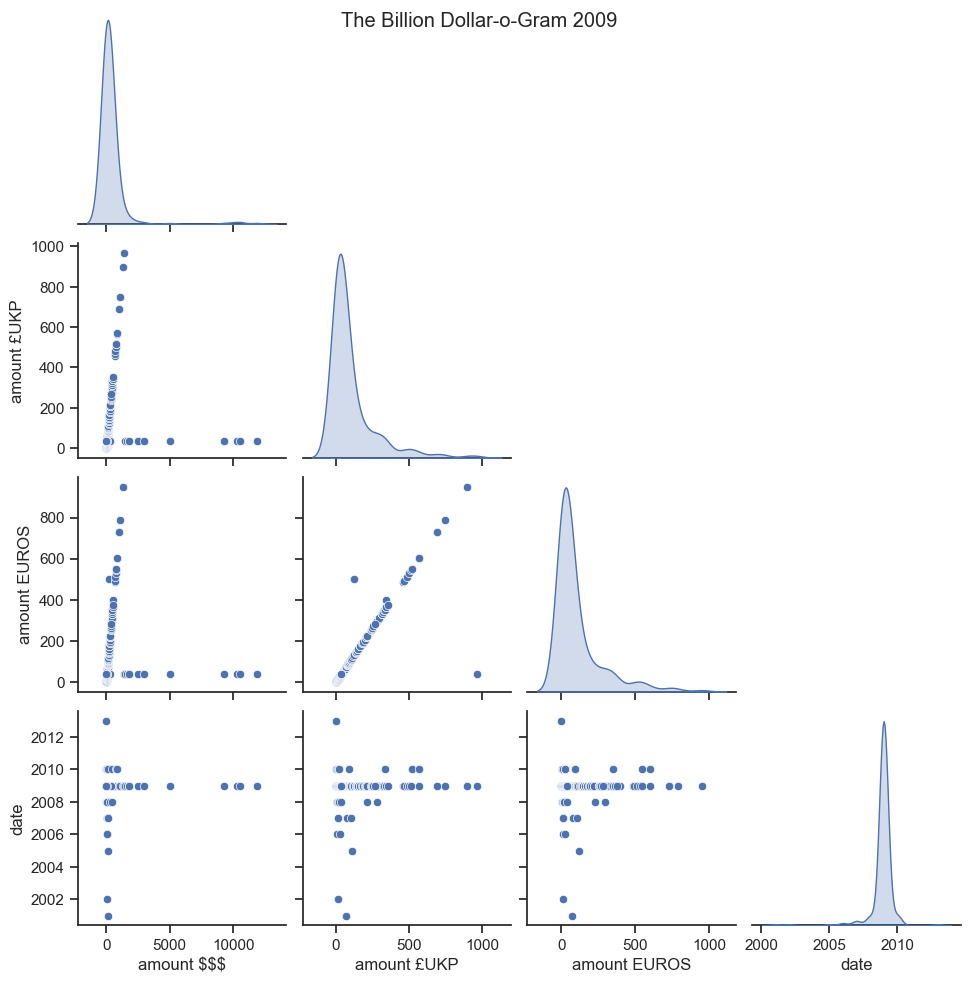

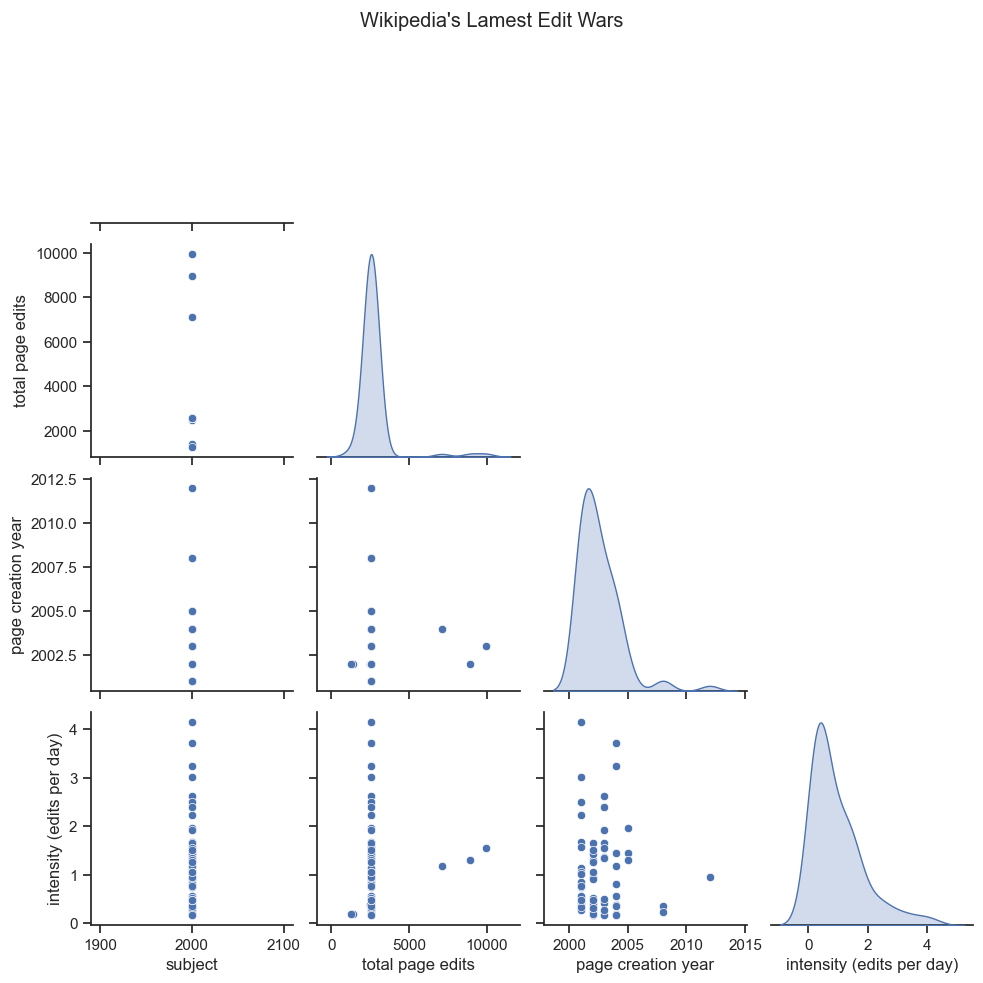

The UK Tax Gap Visualised error occurred: No variables found for grid columns.
Not enough columns/rows to plot for dataset: Who's Suing Whom In The Telecoms Trade


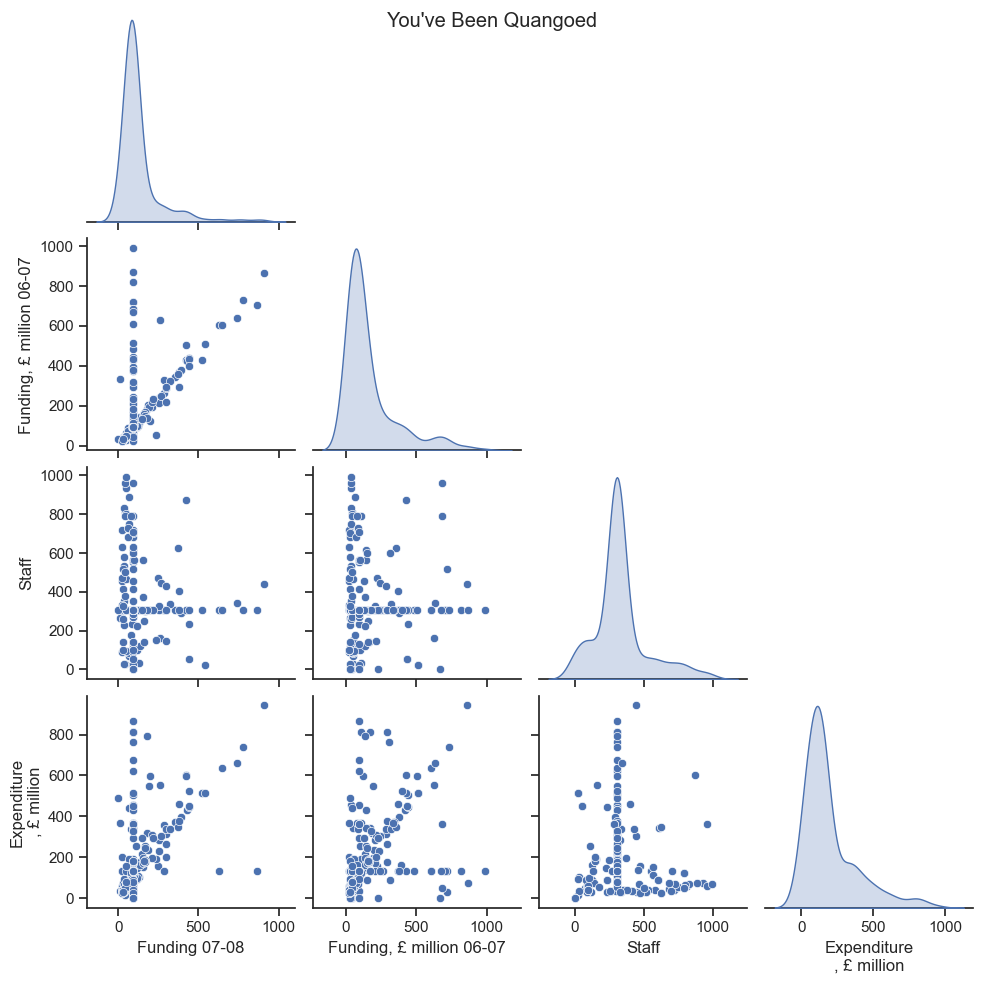

Debtris error occurred: 
$$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)
Not enough columns/rows to plot for dataset: How Much Carbon..
Not enough columns/rows to plot for dataset: Horoscoped
Not enough columns/rows to plot for dataset: Books Everyone Should Read


ValueError: 
$$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 750x750 with 6 Axes>

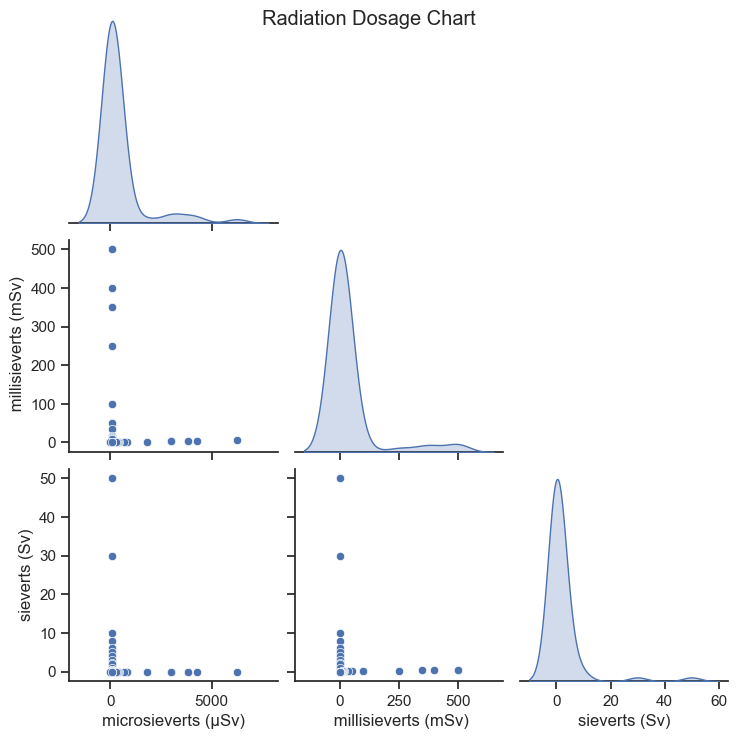

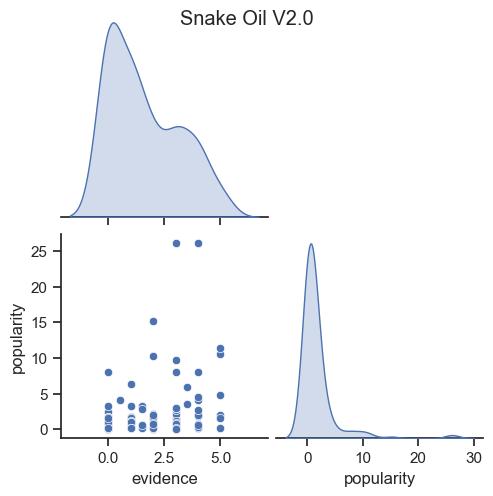

Not enough columns/rows to plot for dataset: The Sunscreen Smokescreen
Is The HPV Vaccine Safe? error occurred: No variables found for grid columns.
Not enough columns/rows to plot for dataset: What are the Wall St Protestors So Angry About?
Not enough columns/rows to plot for dataset: Scales of Devastation
Not enough columns/rows to plot for dataset: Hollywood Budgets


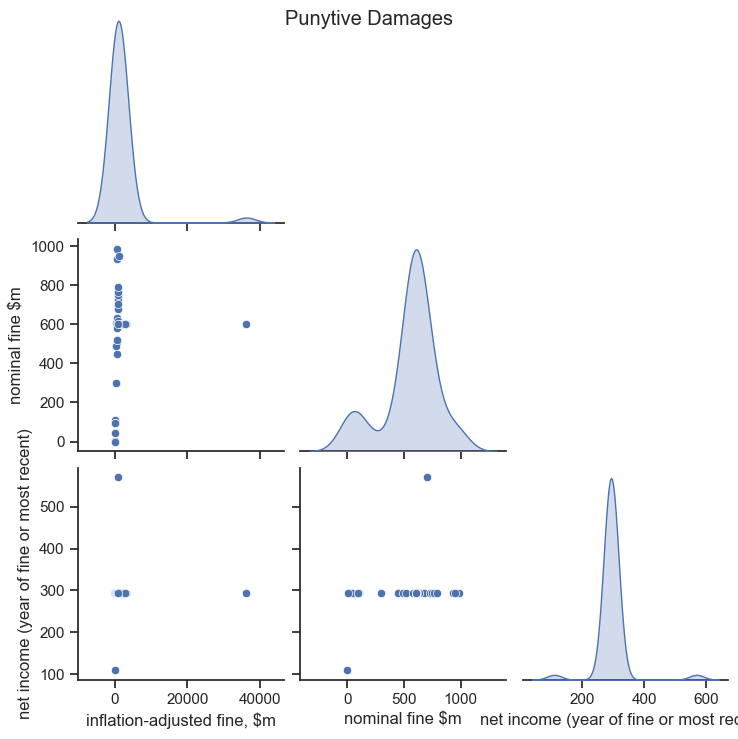

Not enough columns/rows to plot for dataset: How Many Gigatons of CO2?
Not enough columns/rows to plot for dataset: 20th Century Death
Not enough columns/rows to plot for dataset: Which Flu Virus?


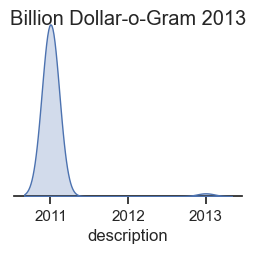

Not enough columns/rows to plot for dataset: World's Biggest Data Breaches
Snake Oil Superfoods error occurred: No variables found for grid columns.
Not enough columns/rows to plot for dataset: Codebases
Snake Oil Supplements error occurred: No variables found for grid columns.
Not enough columns/rows to plot for dataset: The Effects of Meditation/Mindfulness


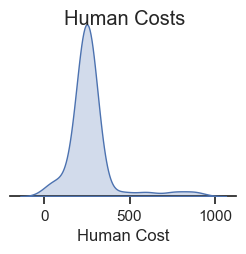

Not enough columns/rows to plot for dataset: Antibiotic Resistance


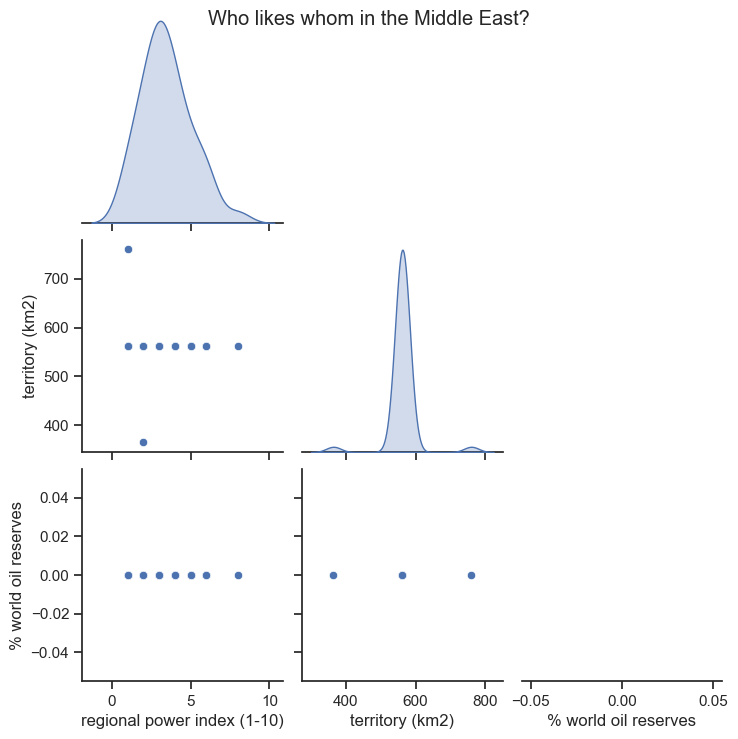

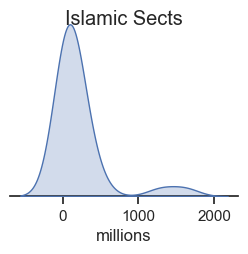

Not enough columns/rows to plot for dataset: Common Mythconceptions


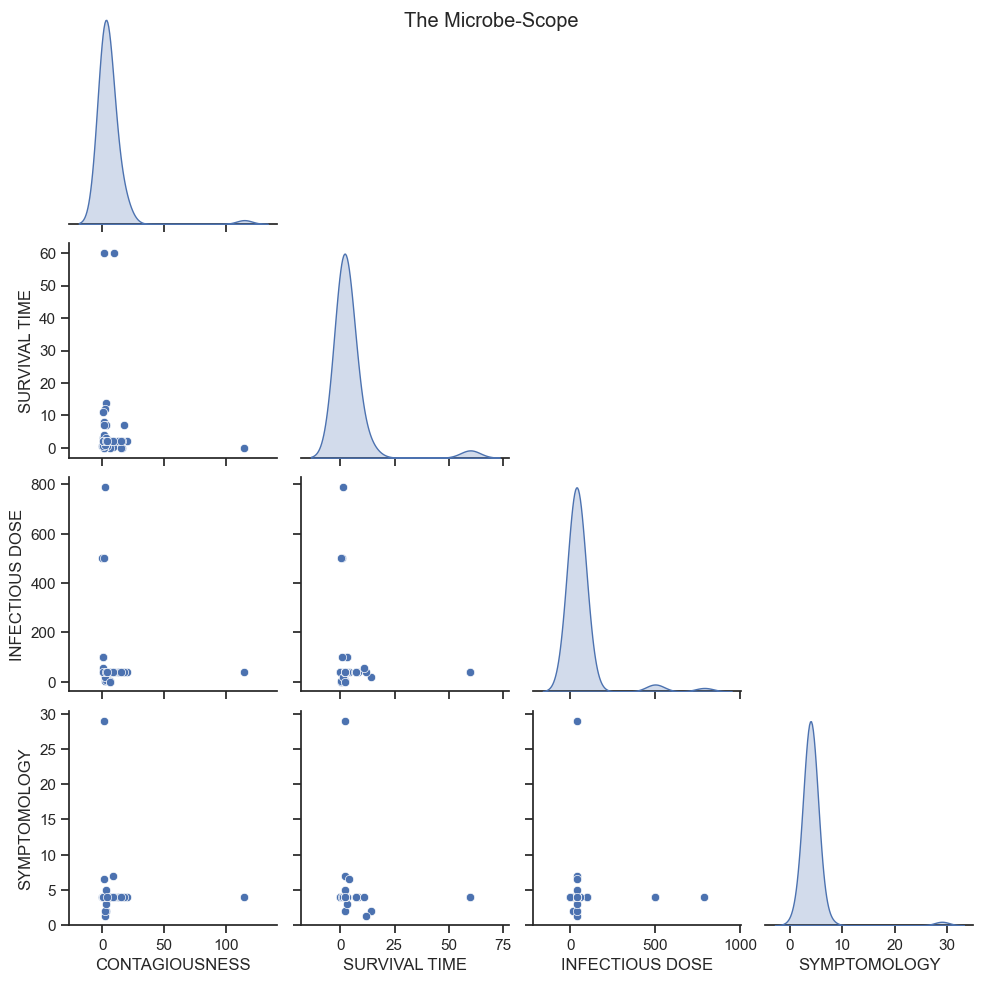

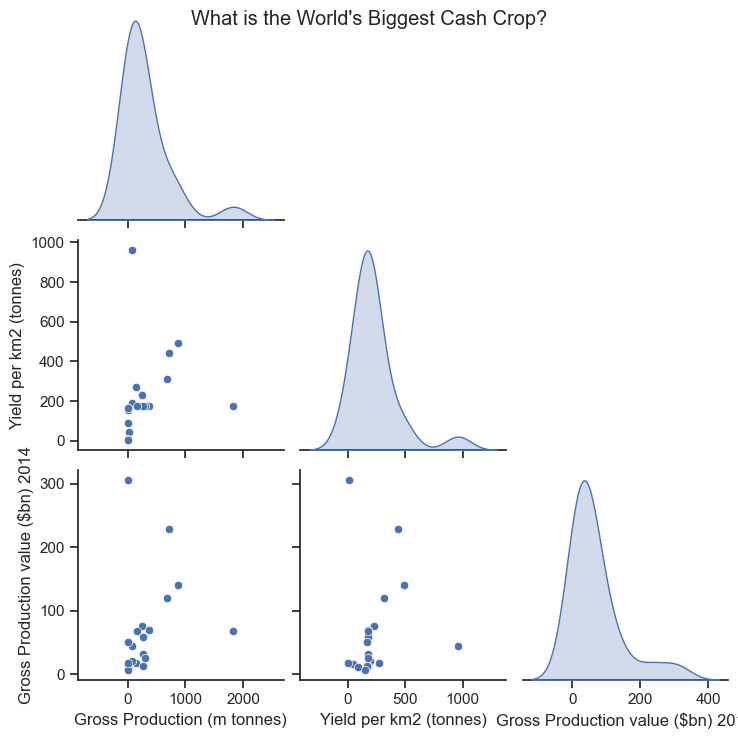

Cocktails error occurred: No variables found for grid columns.
Not enough columns/rows to plot for dataset: Geoengineering the Climate
Not enough columns/rows to plot for dataset: Oil Well
Not enough columns/rows to plot for dataset: Timeline of the Far Future
A Taxonomy of Hipster Coffee-Shop Names error occurred: No variables found for grid columns.
Not enough columns/rows to plot for dataset: Out of Your Hands
Not enough columns/rows to plot for dataset: Top 500 Passwords
Not enough columns/rows to plot for dataset: Money Too Tight to Mention?
Not enough columns/rows to plot for dataset: Vitamin D


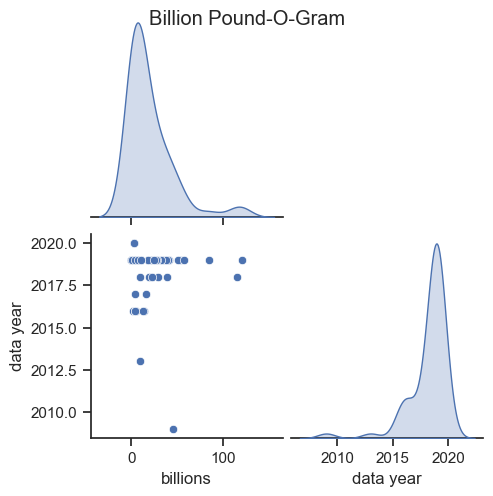

Rhetological Fallacies error occurred: No variables found for grid columns.
Arguments Rhétologiques Fallacieux error occurred: No variables found for grid columns.
Good Relationtips error occurred: No variables found for grid columns.


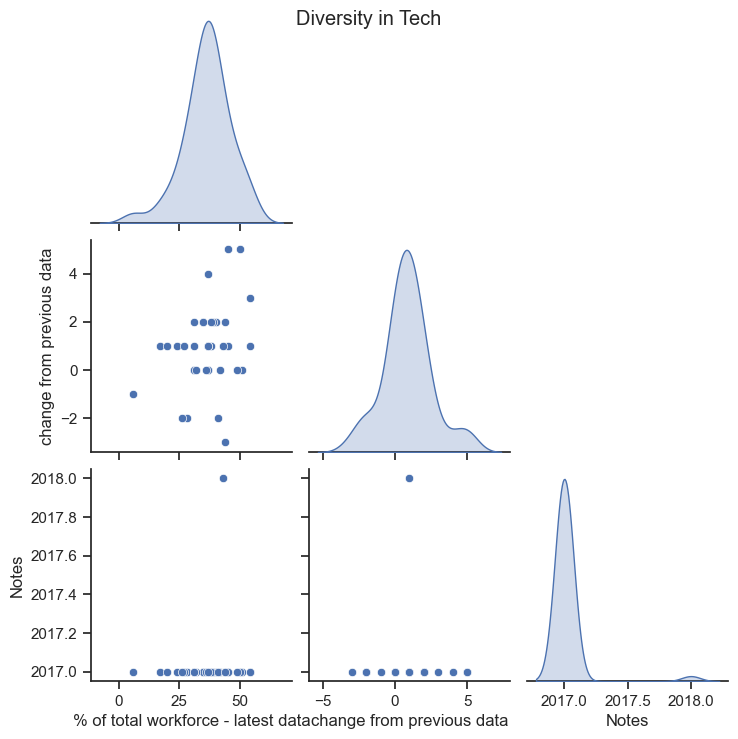

Not enough columns/rows to plot for dataset: Novels Everyone Should Read


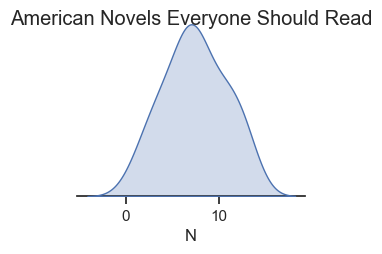

Not enough columns/rows to plot for dataset: Selling Out
Not enough columns/rows to plot for dataset: Gender Pay Gap US
Not enough columns/rows to plot for dataset: Gender Pay Gap UK
Not enough columns/rows to plot for dataset: Non-Fiction Books Everyone Should Read
Not enough columns/rows to plot for dataset: Based on a *True* True Story?
Not enough columns/rows to plot for dataset: Senseless


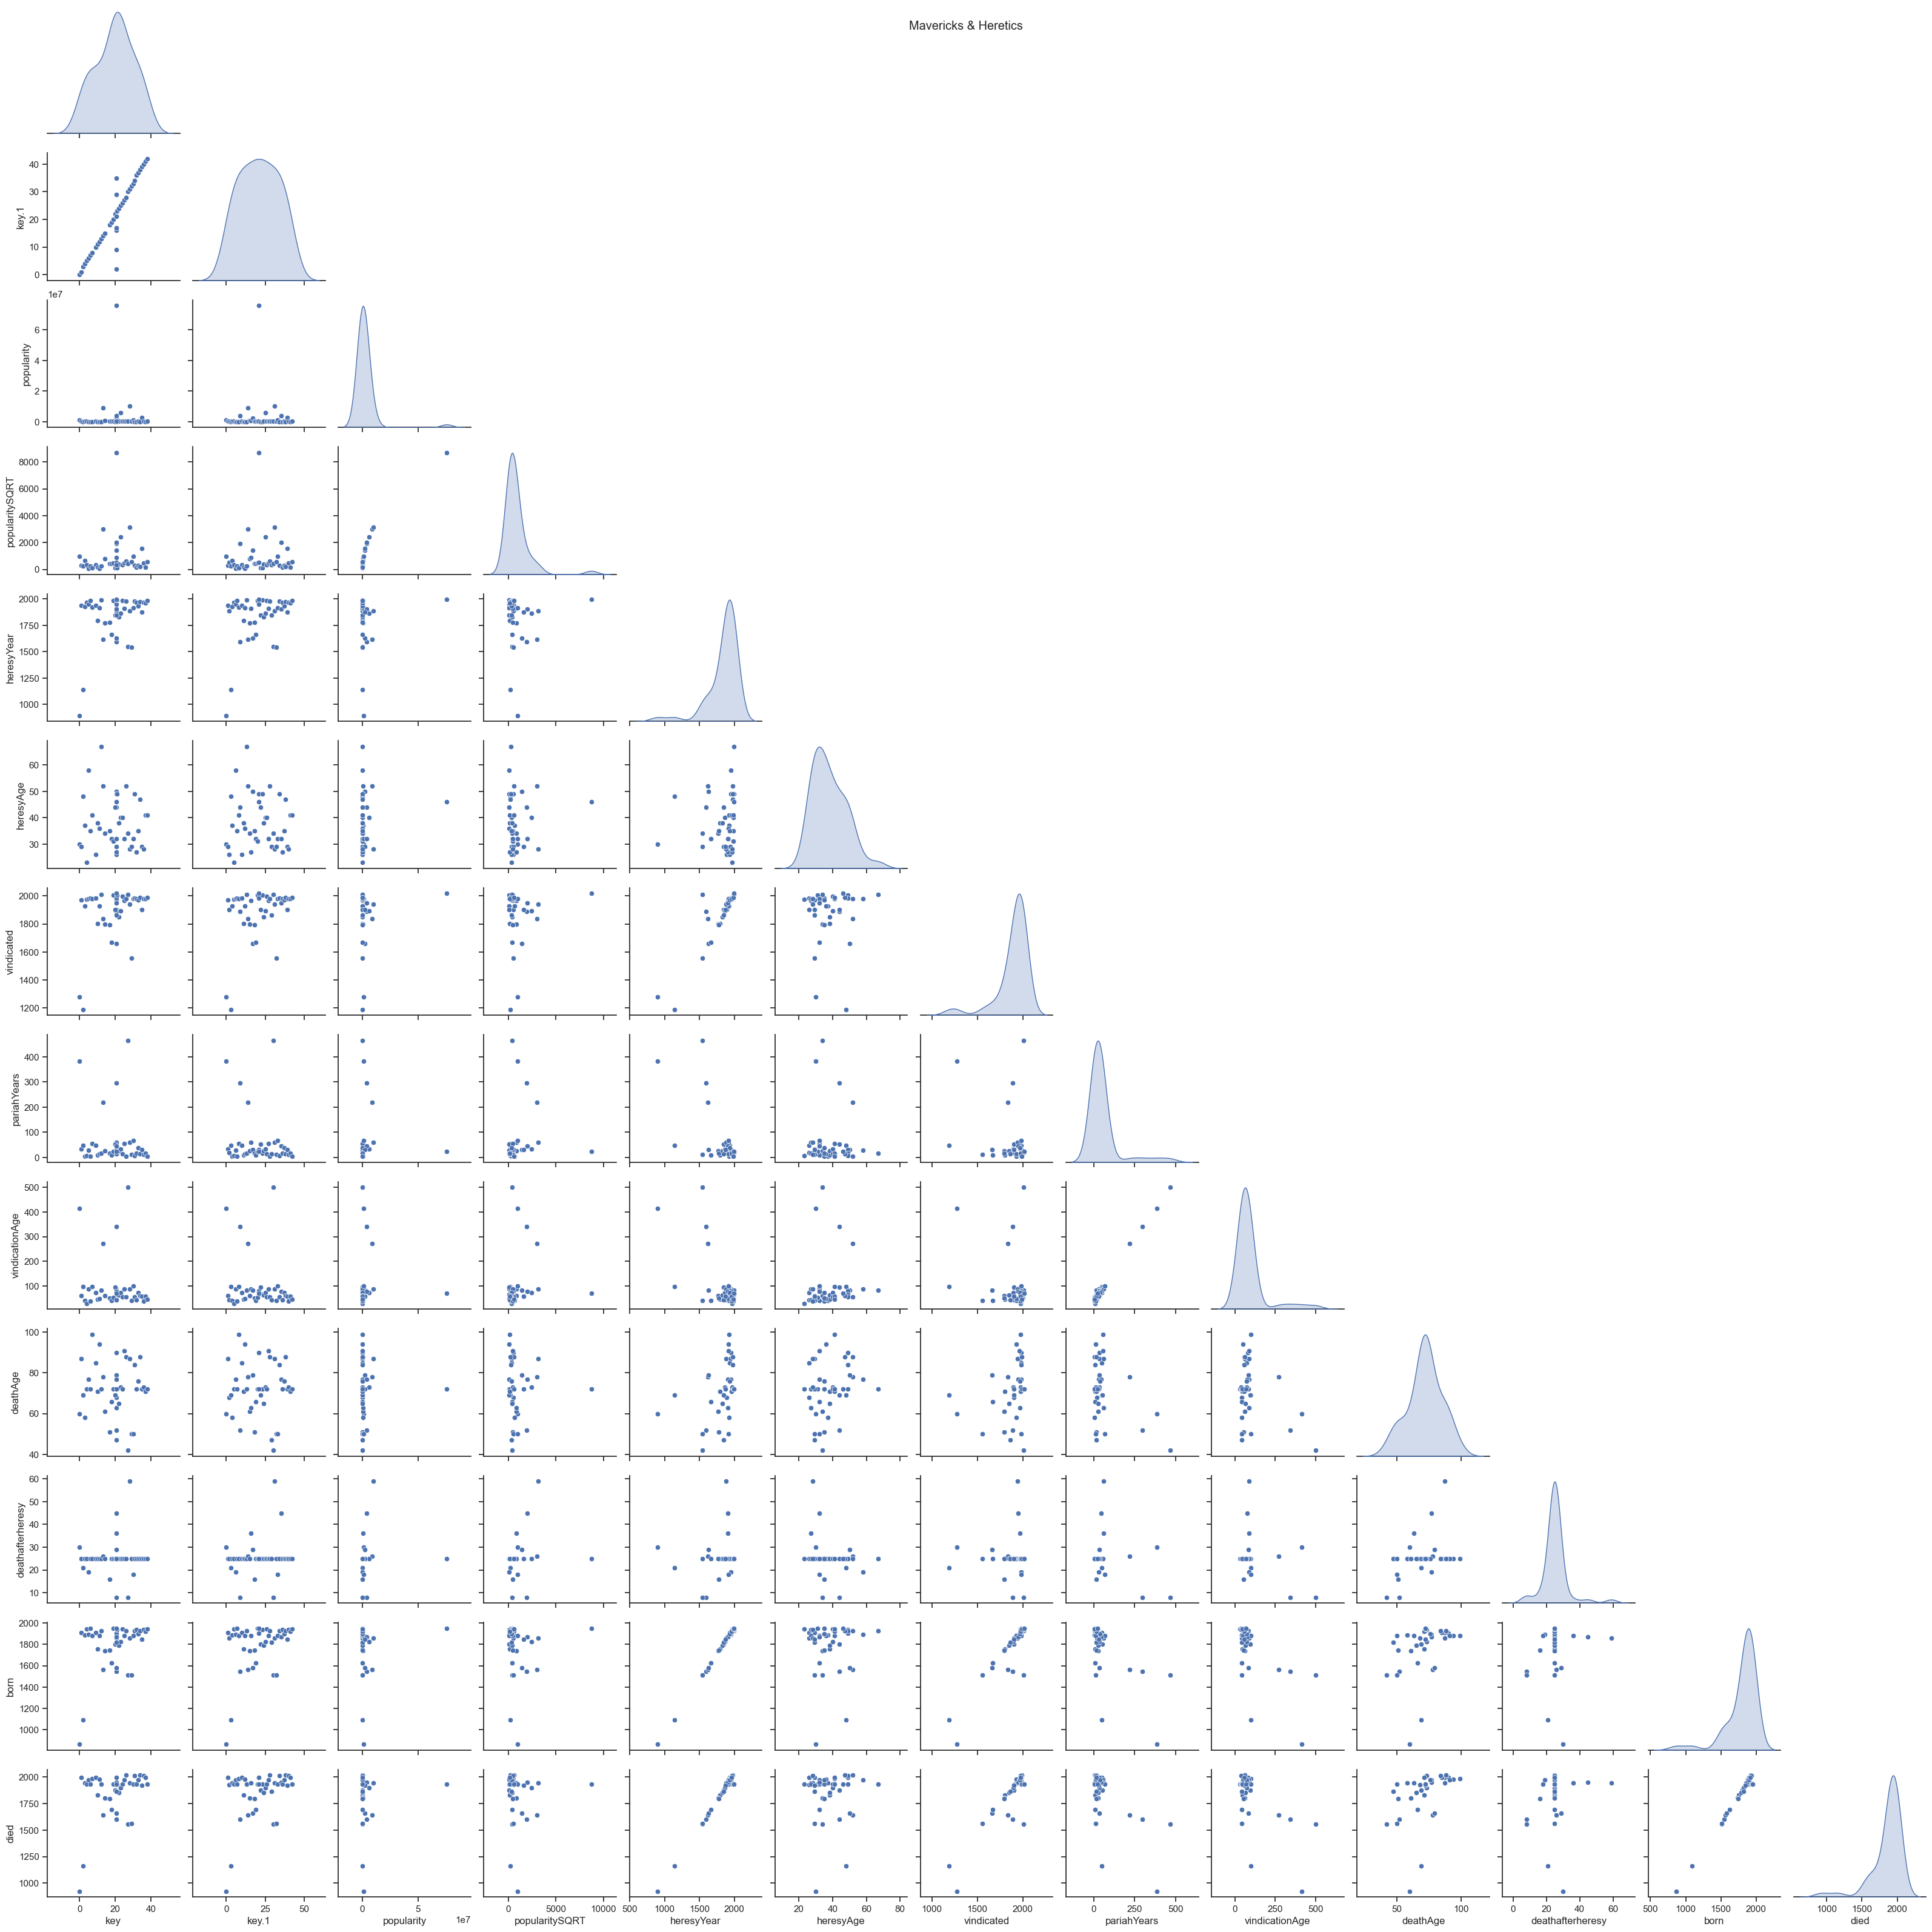

Not enough columns/rows to plot for dataset: UK Government Spending


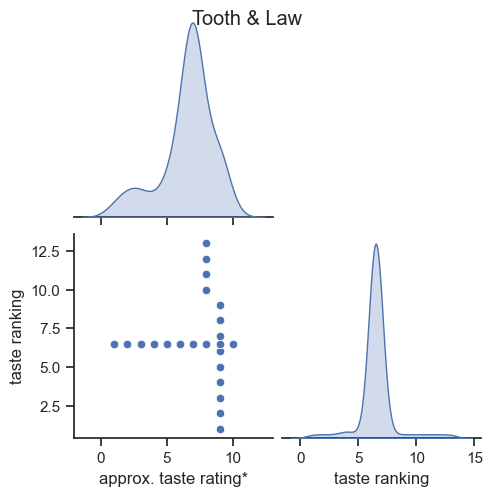

Not enough columns/rows to plot for dataset: UK's Brexit Divorce Bill-ions


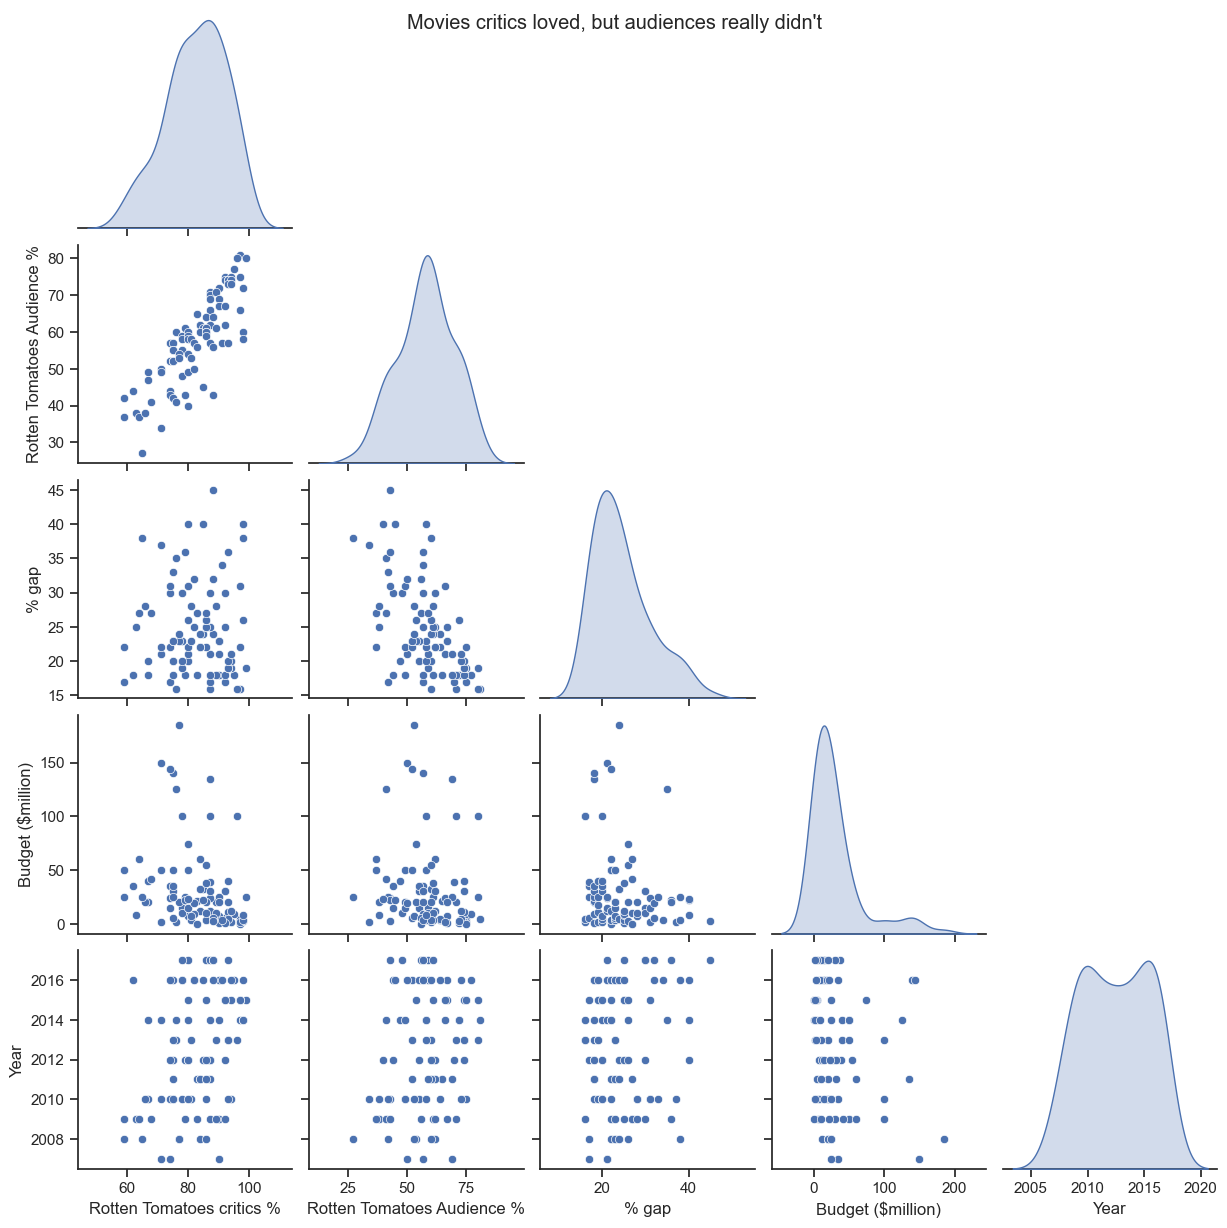

Not enough columns/rows to plot for dataset: Fake News of 2017 and 2018


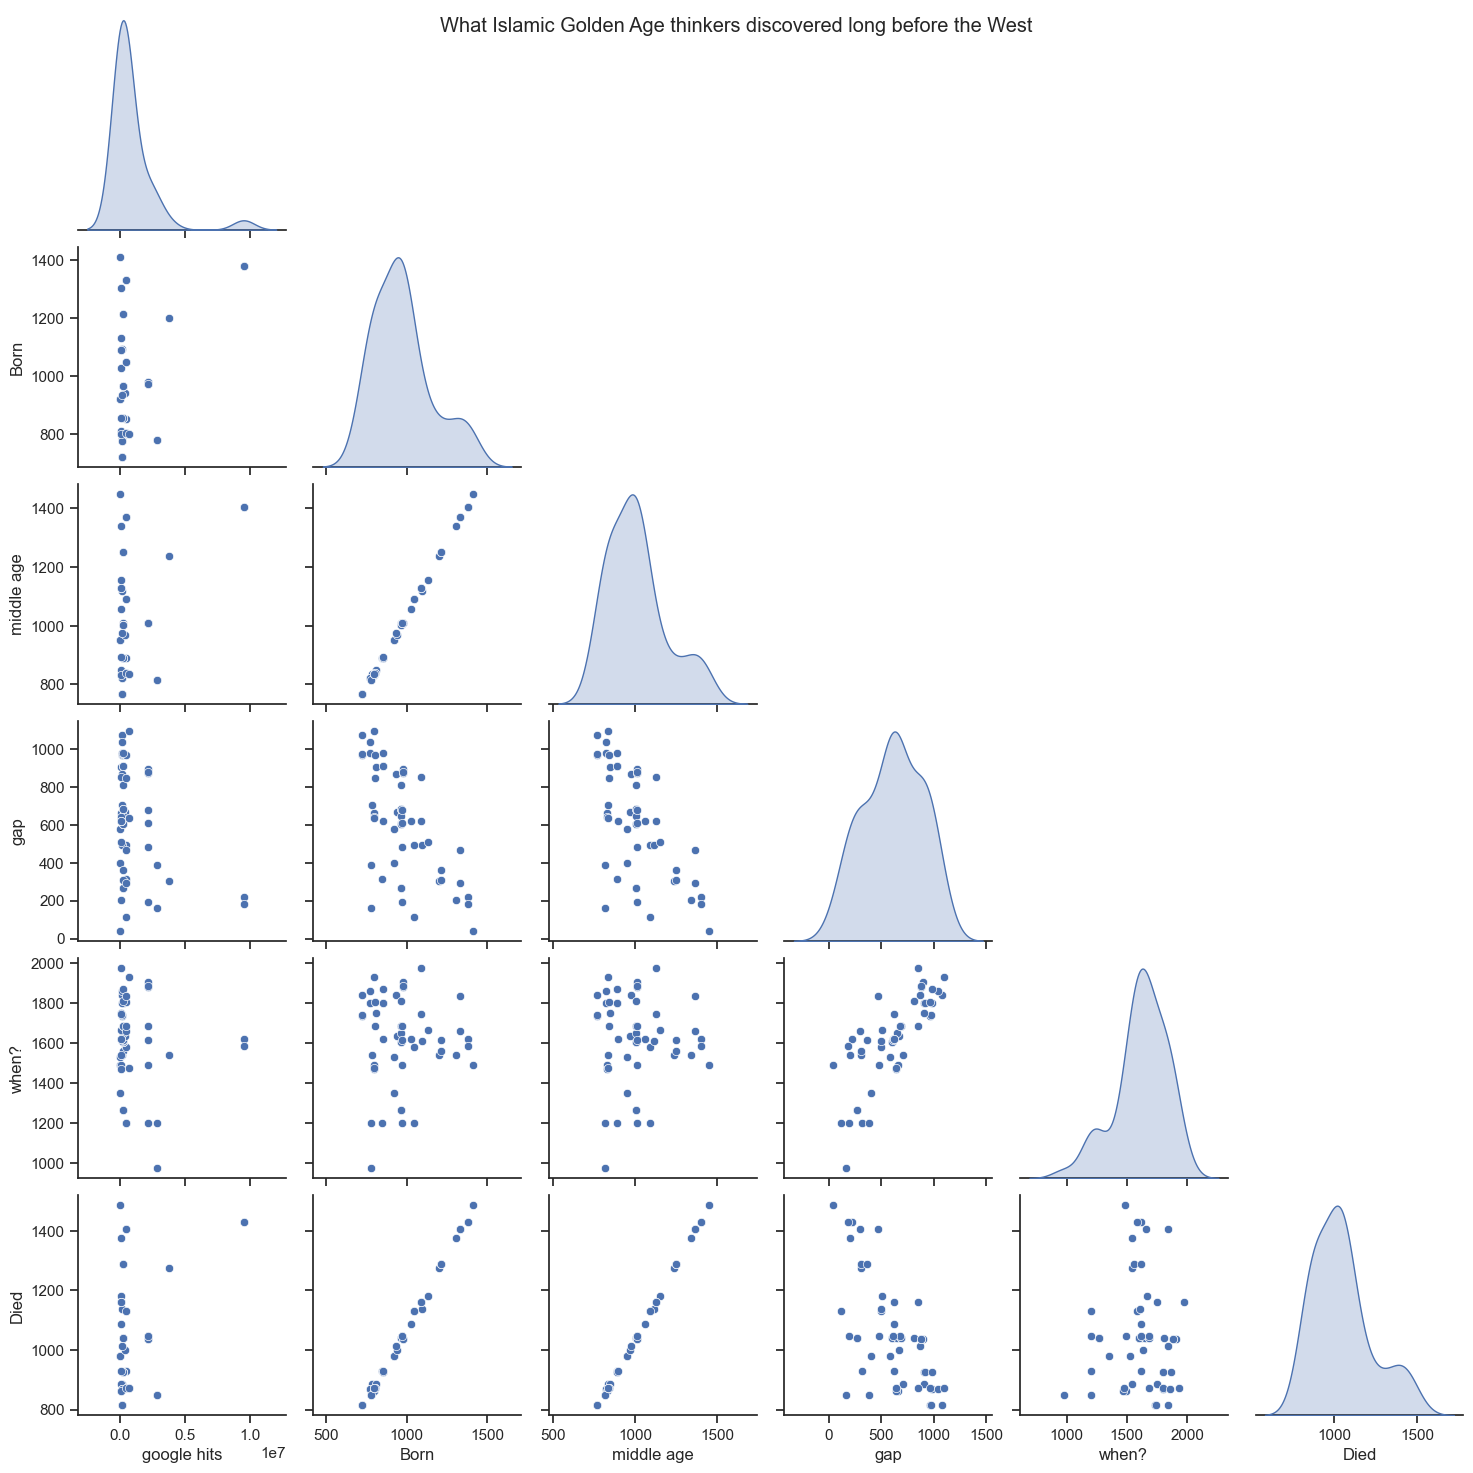

Not enough columns/rows to plot for dataset: The Drake Equation


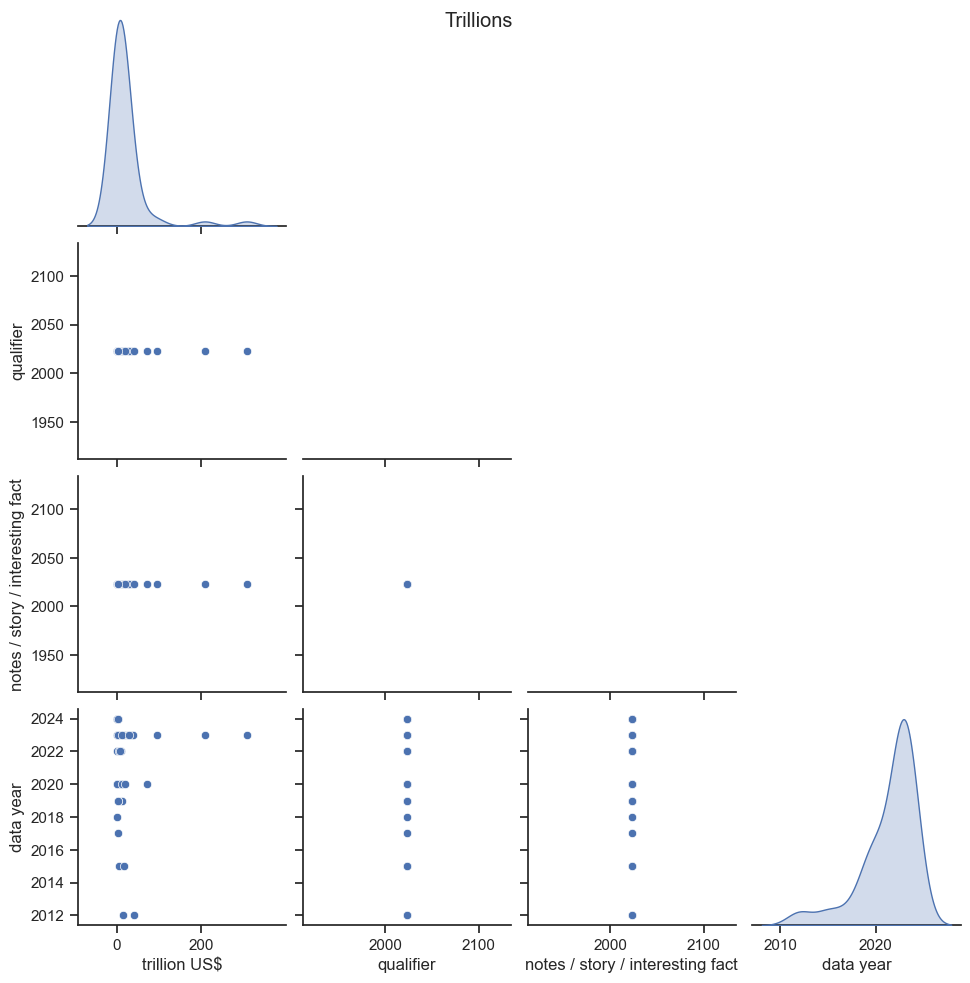

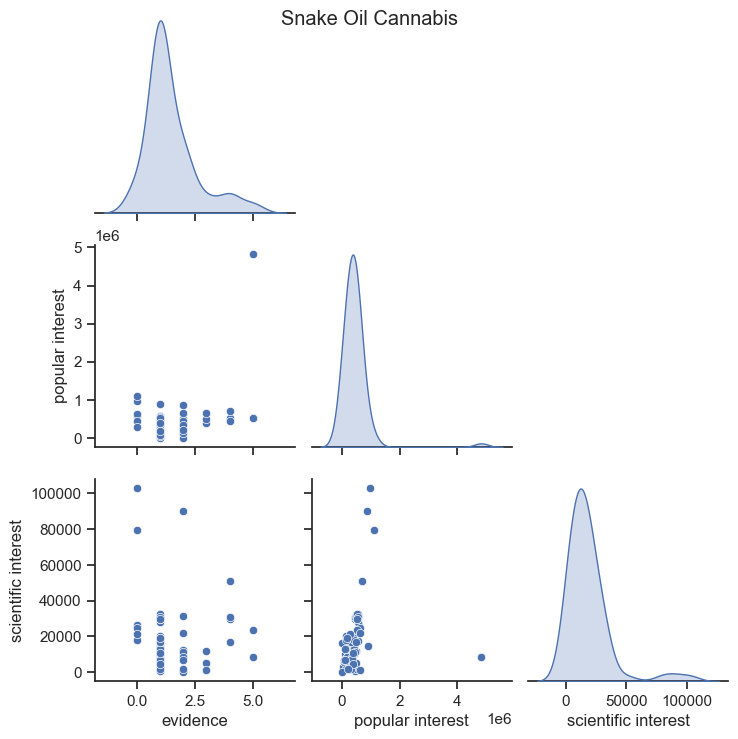

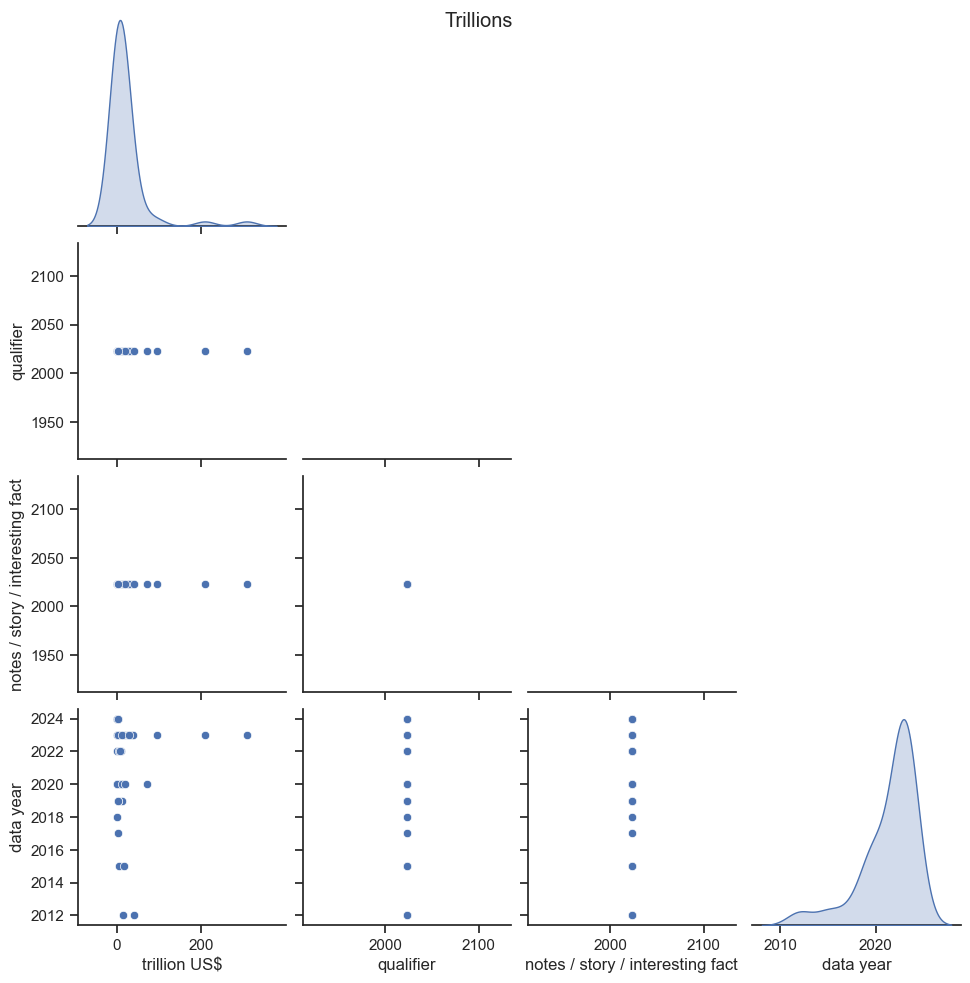

Live Long: What Really Extends Lifespan? error occurred: No variables found for grid columns.


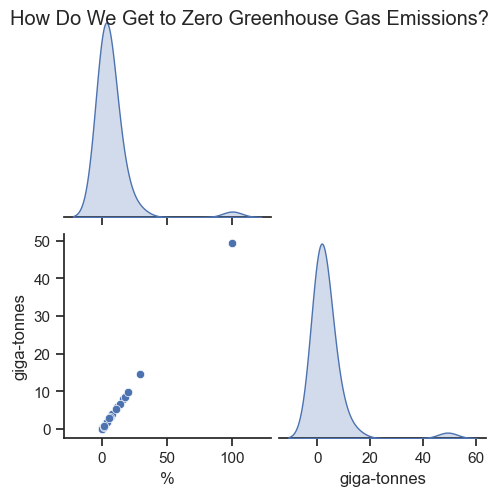

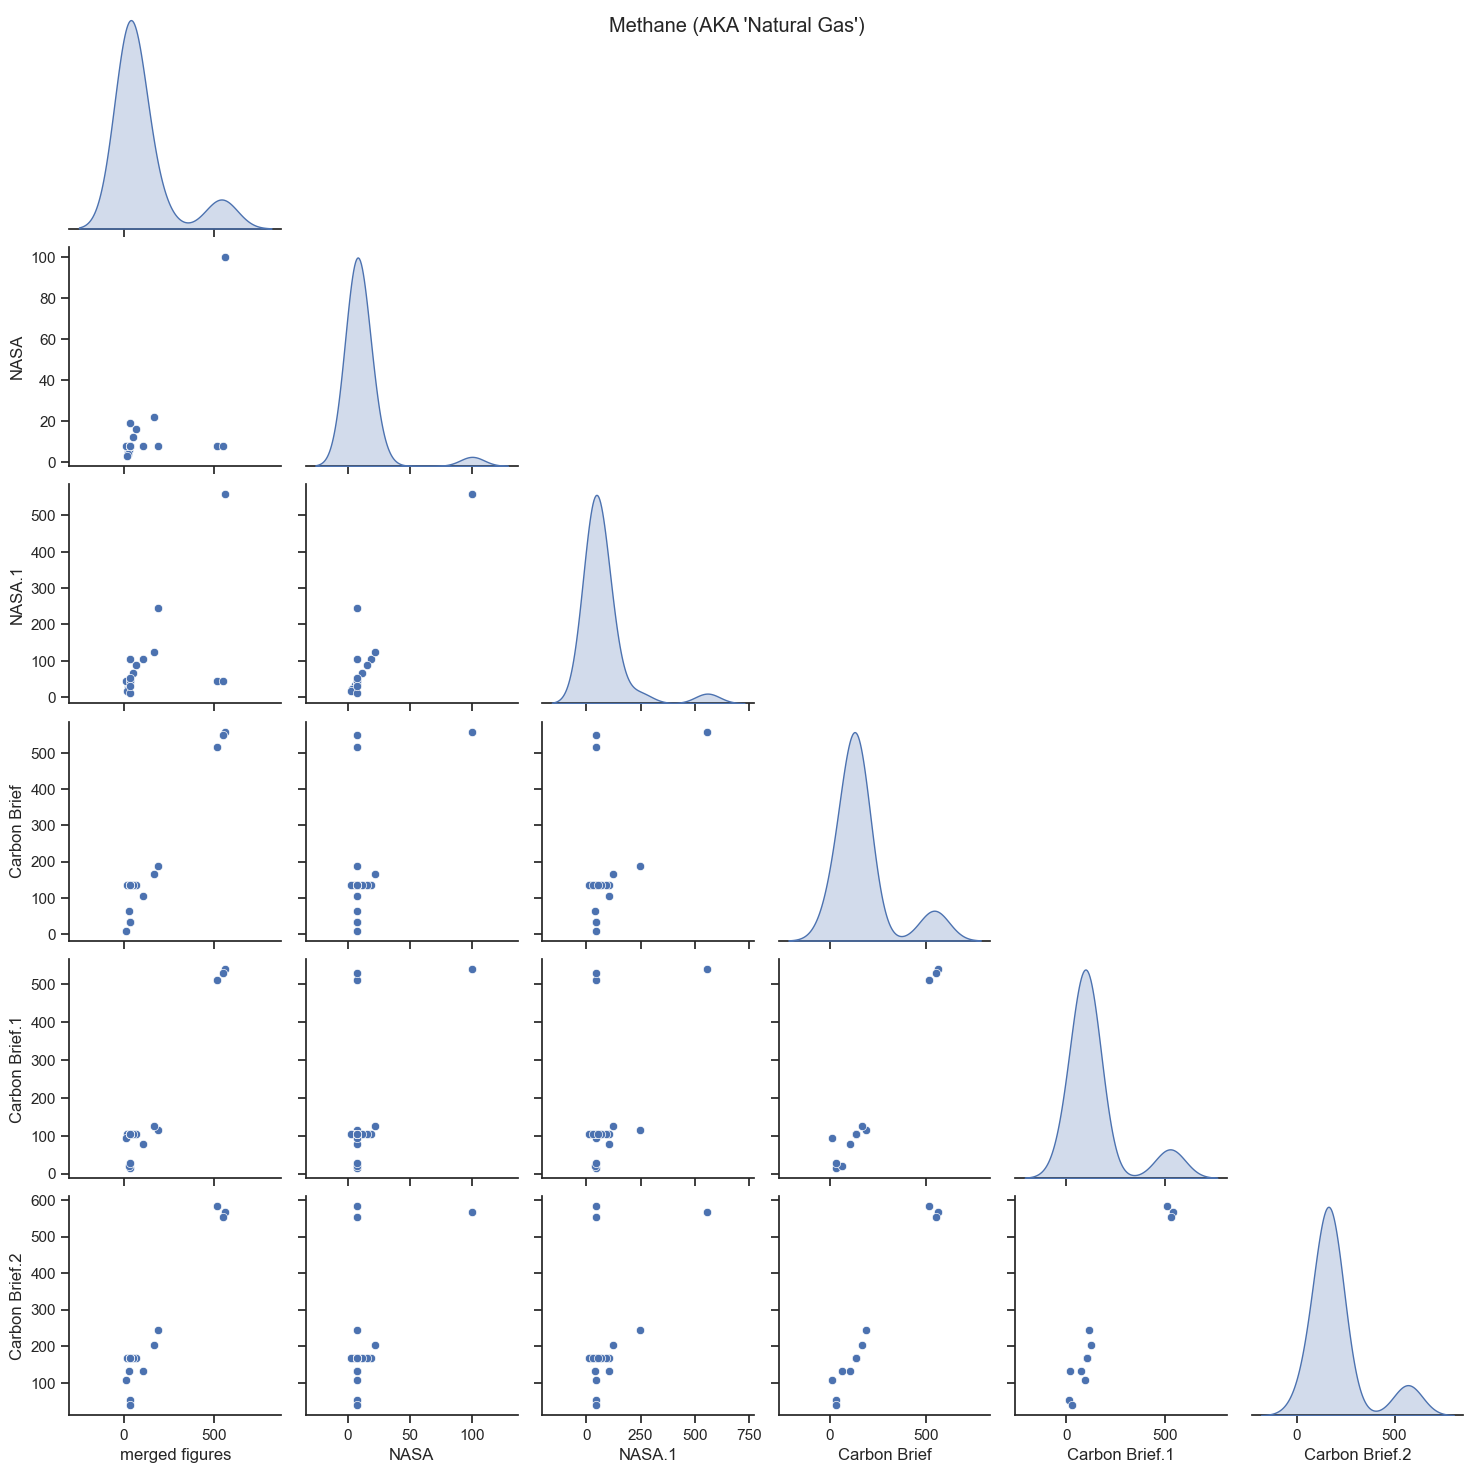

Not enough columns/rows to plot for dataset: A Matter of Fact?


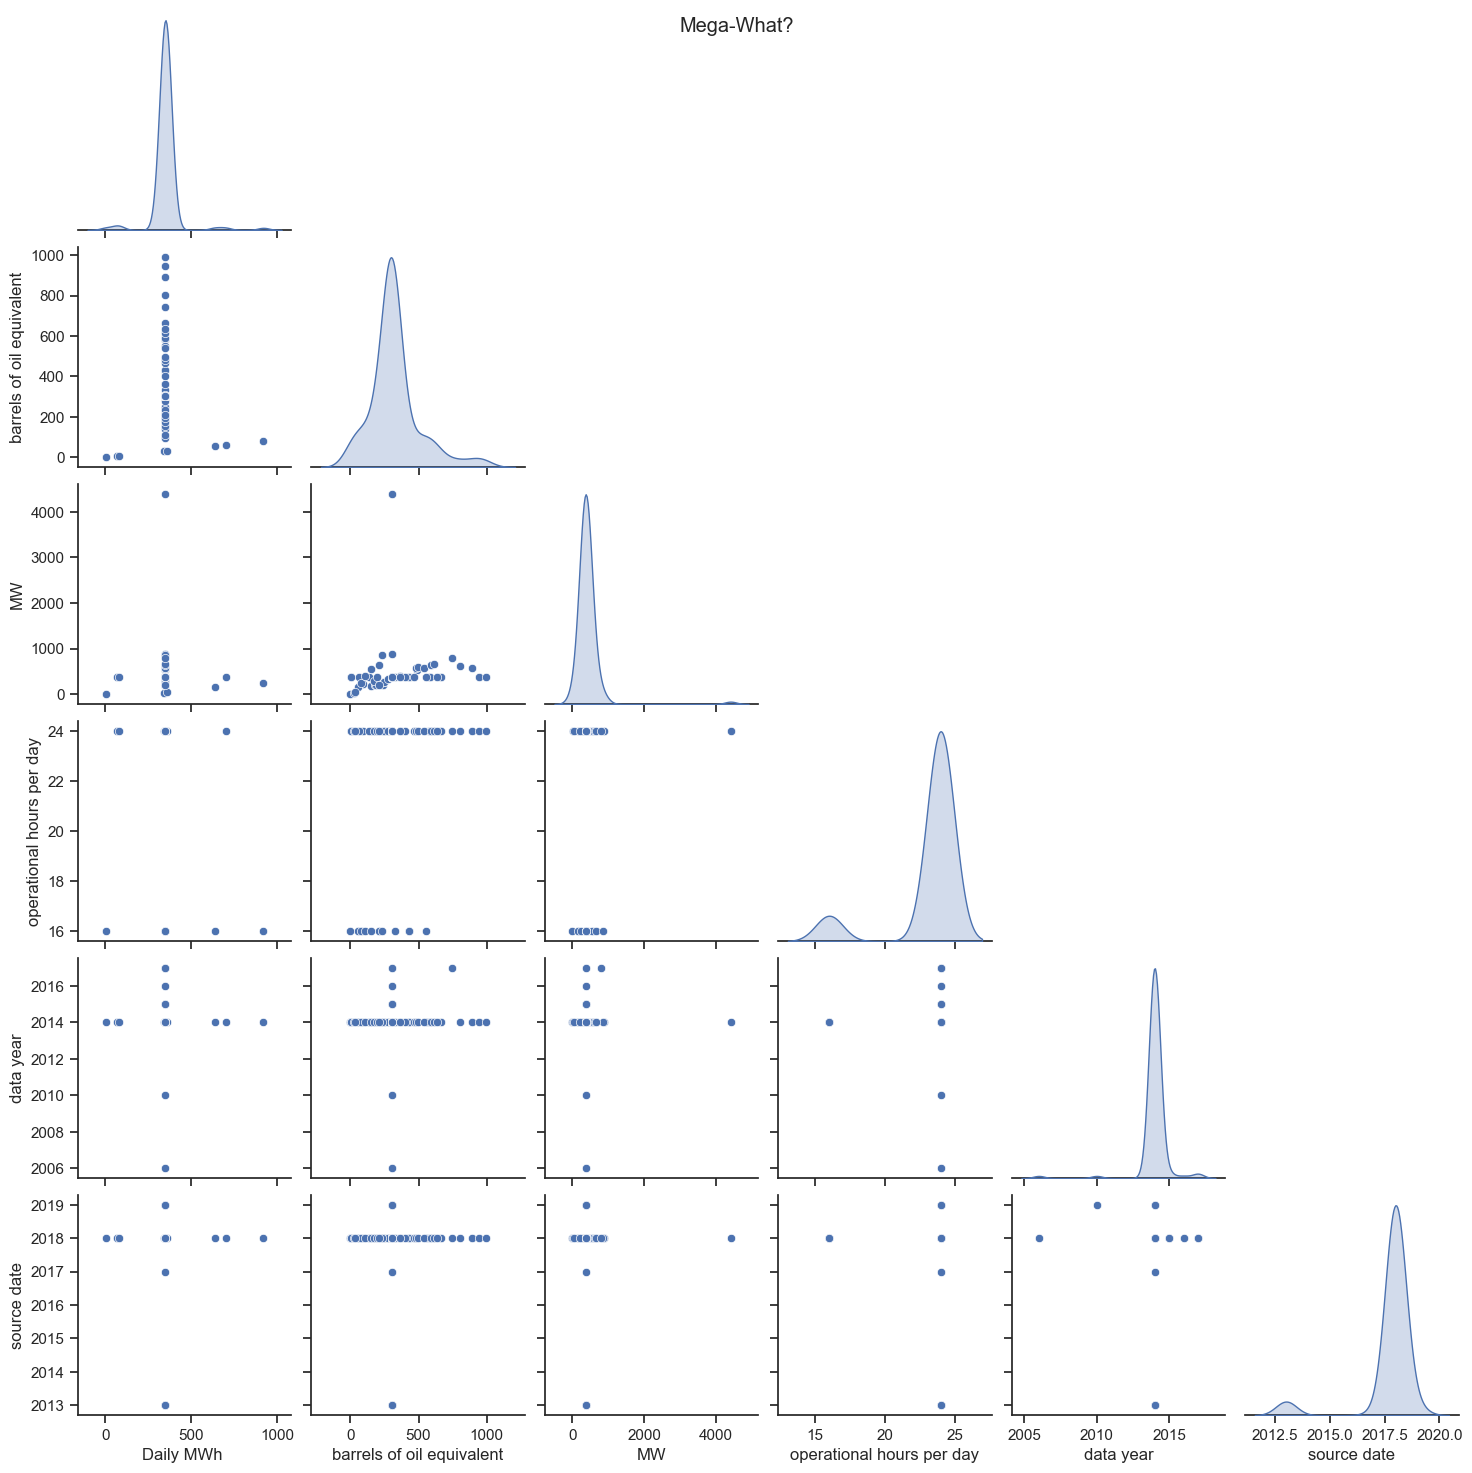

Seaweed error occurred: No variables found for grid columns.
Not enough columns/rows to plot for dataset: Coronavirus Myths & Misconceptions
Not enough columns/rows to plot for dataset: COVID-19 #Coronavirus Data Pack


Not enough columns/rows to plot for dataset: Coronavirus Riskiest Activities
Not enough columns/rows to plot for dataset: Coronavirus Vaccines vs The Variants
Not enough columns/rows to plot for dataset: Ransomware Attacks
400+ Words Invented by Shakespeare error occurred: No variables found for grid columns.
Not enough columns/rows to plot for dataset: The 10 Categories of Password


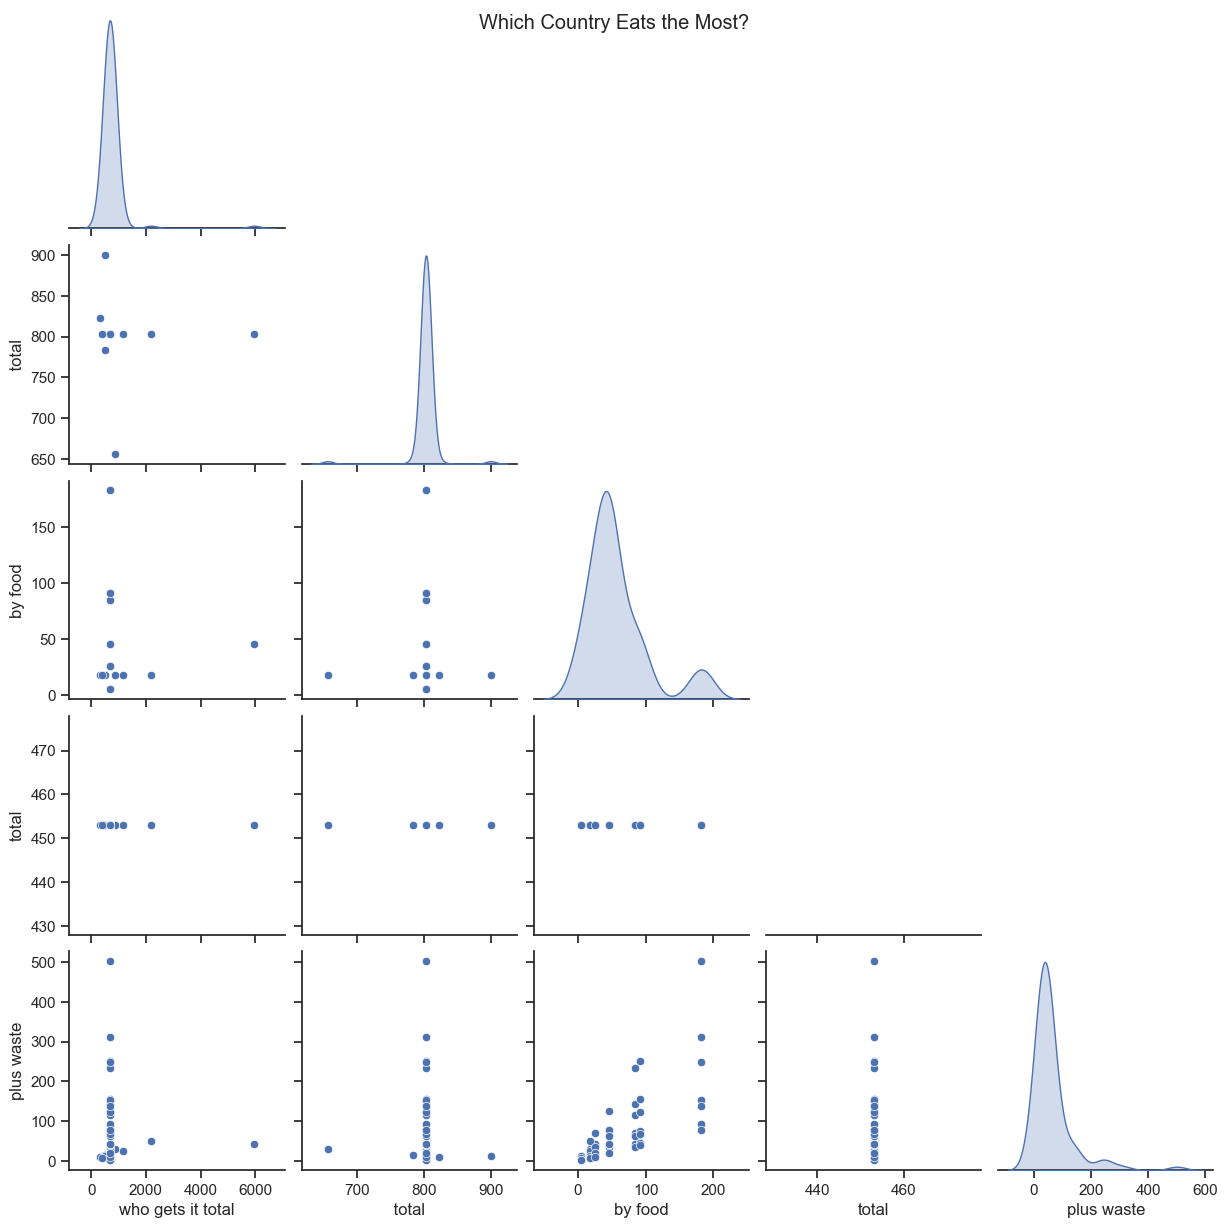

Not enough columns/rows to plot for dataset: How to Get the World to Netzero Carbon Emissions by 2050
Not enough columns/rows to plot for dataset: Food Waste


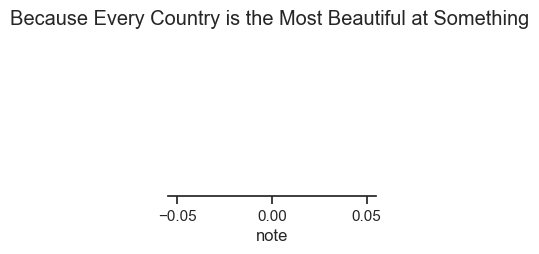

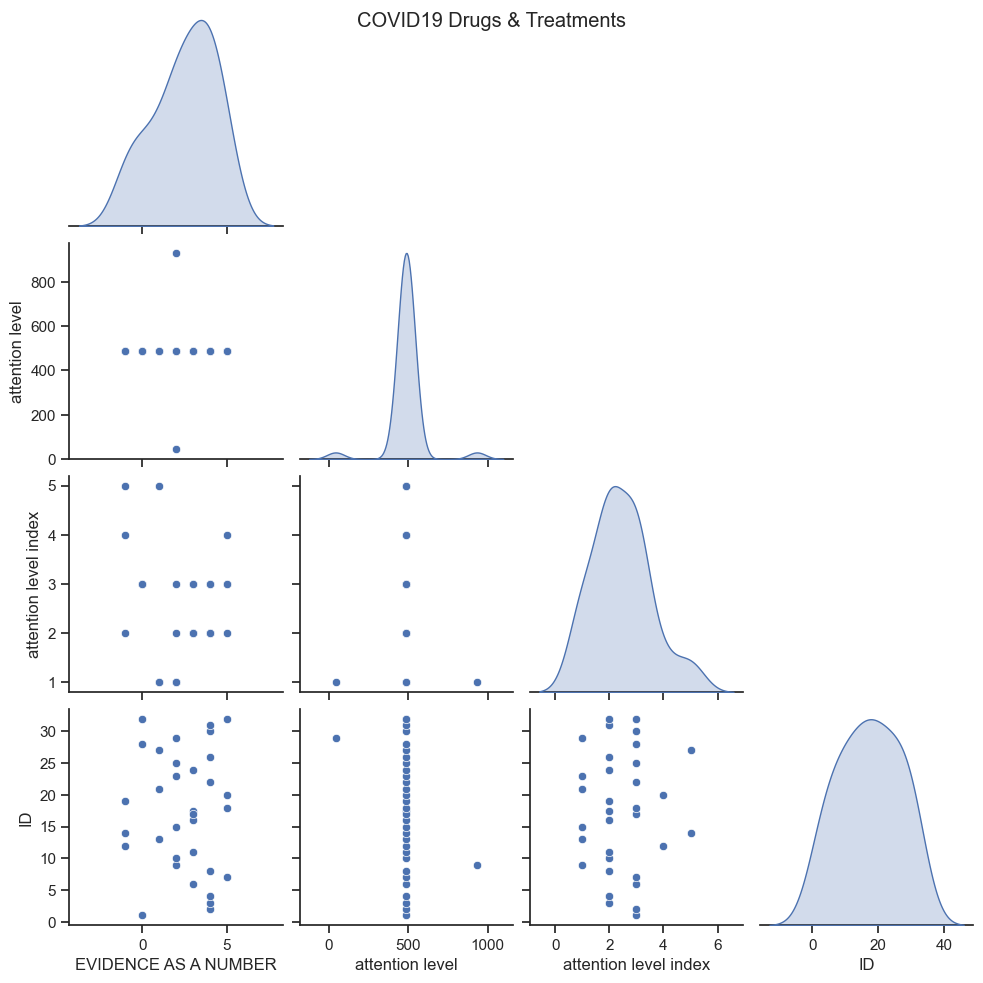

Not enough columns/rows to plot for dataset: Russian Gas & Oil
% Renewable Electricity by Country error occurred: No variables found for grid columns.
Not enough columns/rows to plot for dataset: How to Get the USA to Net Zero Carbon by 2050
Not enough columns/rows to plot for dataset: Most Beautiful News of the Year 2022


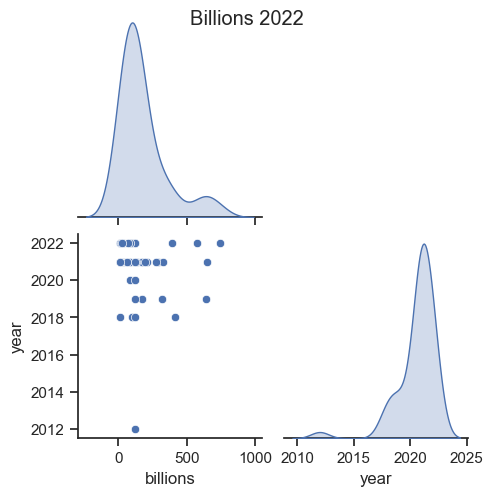

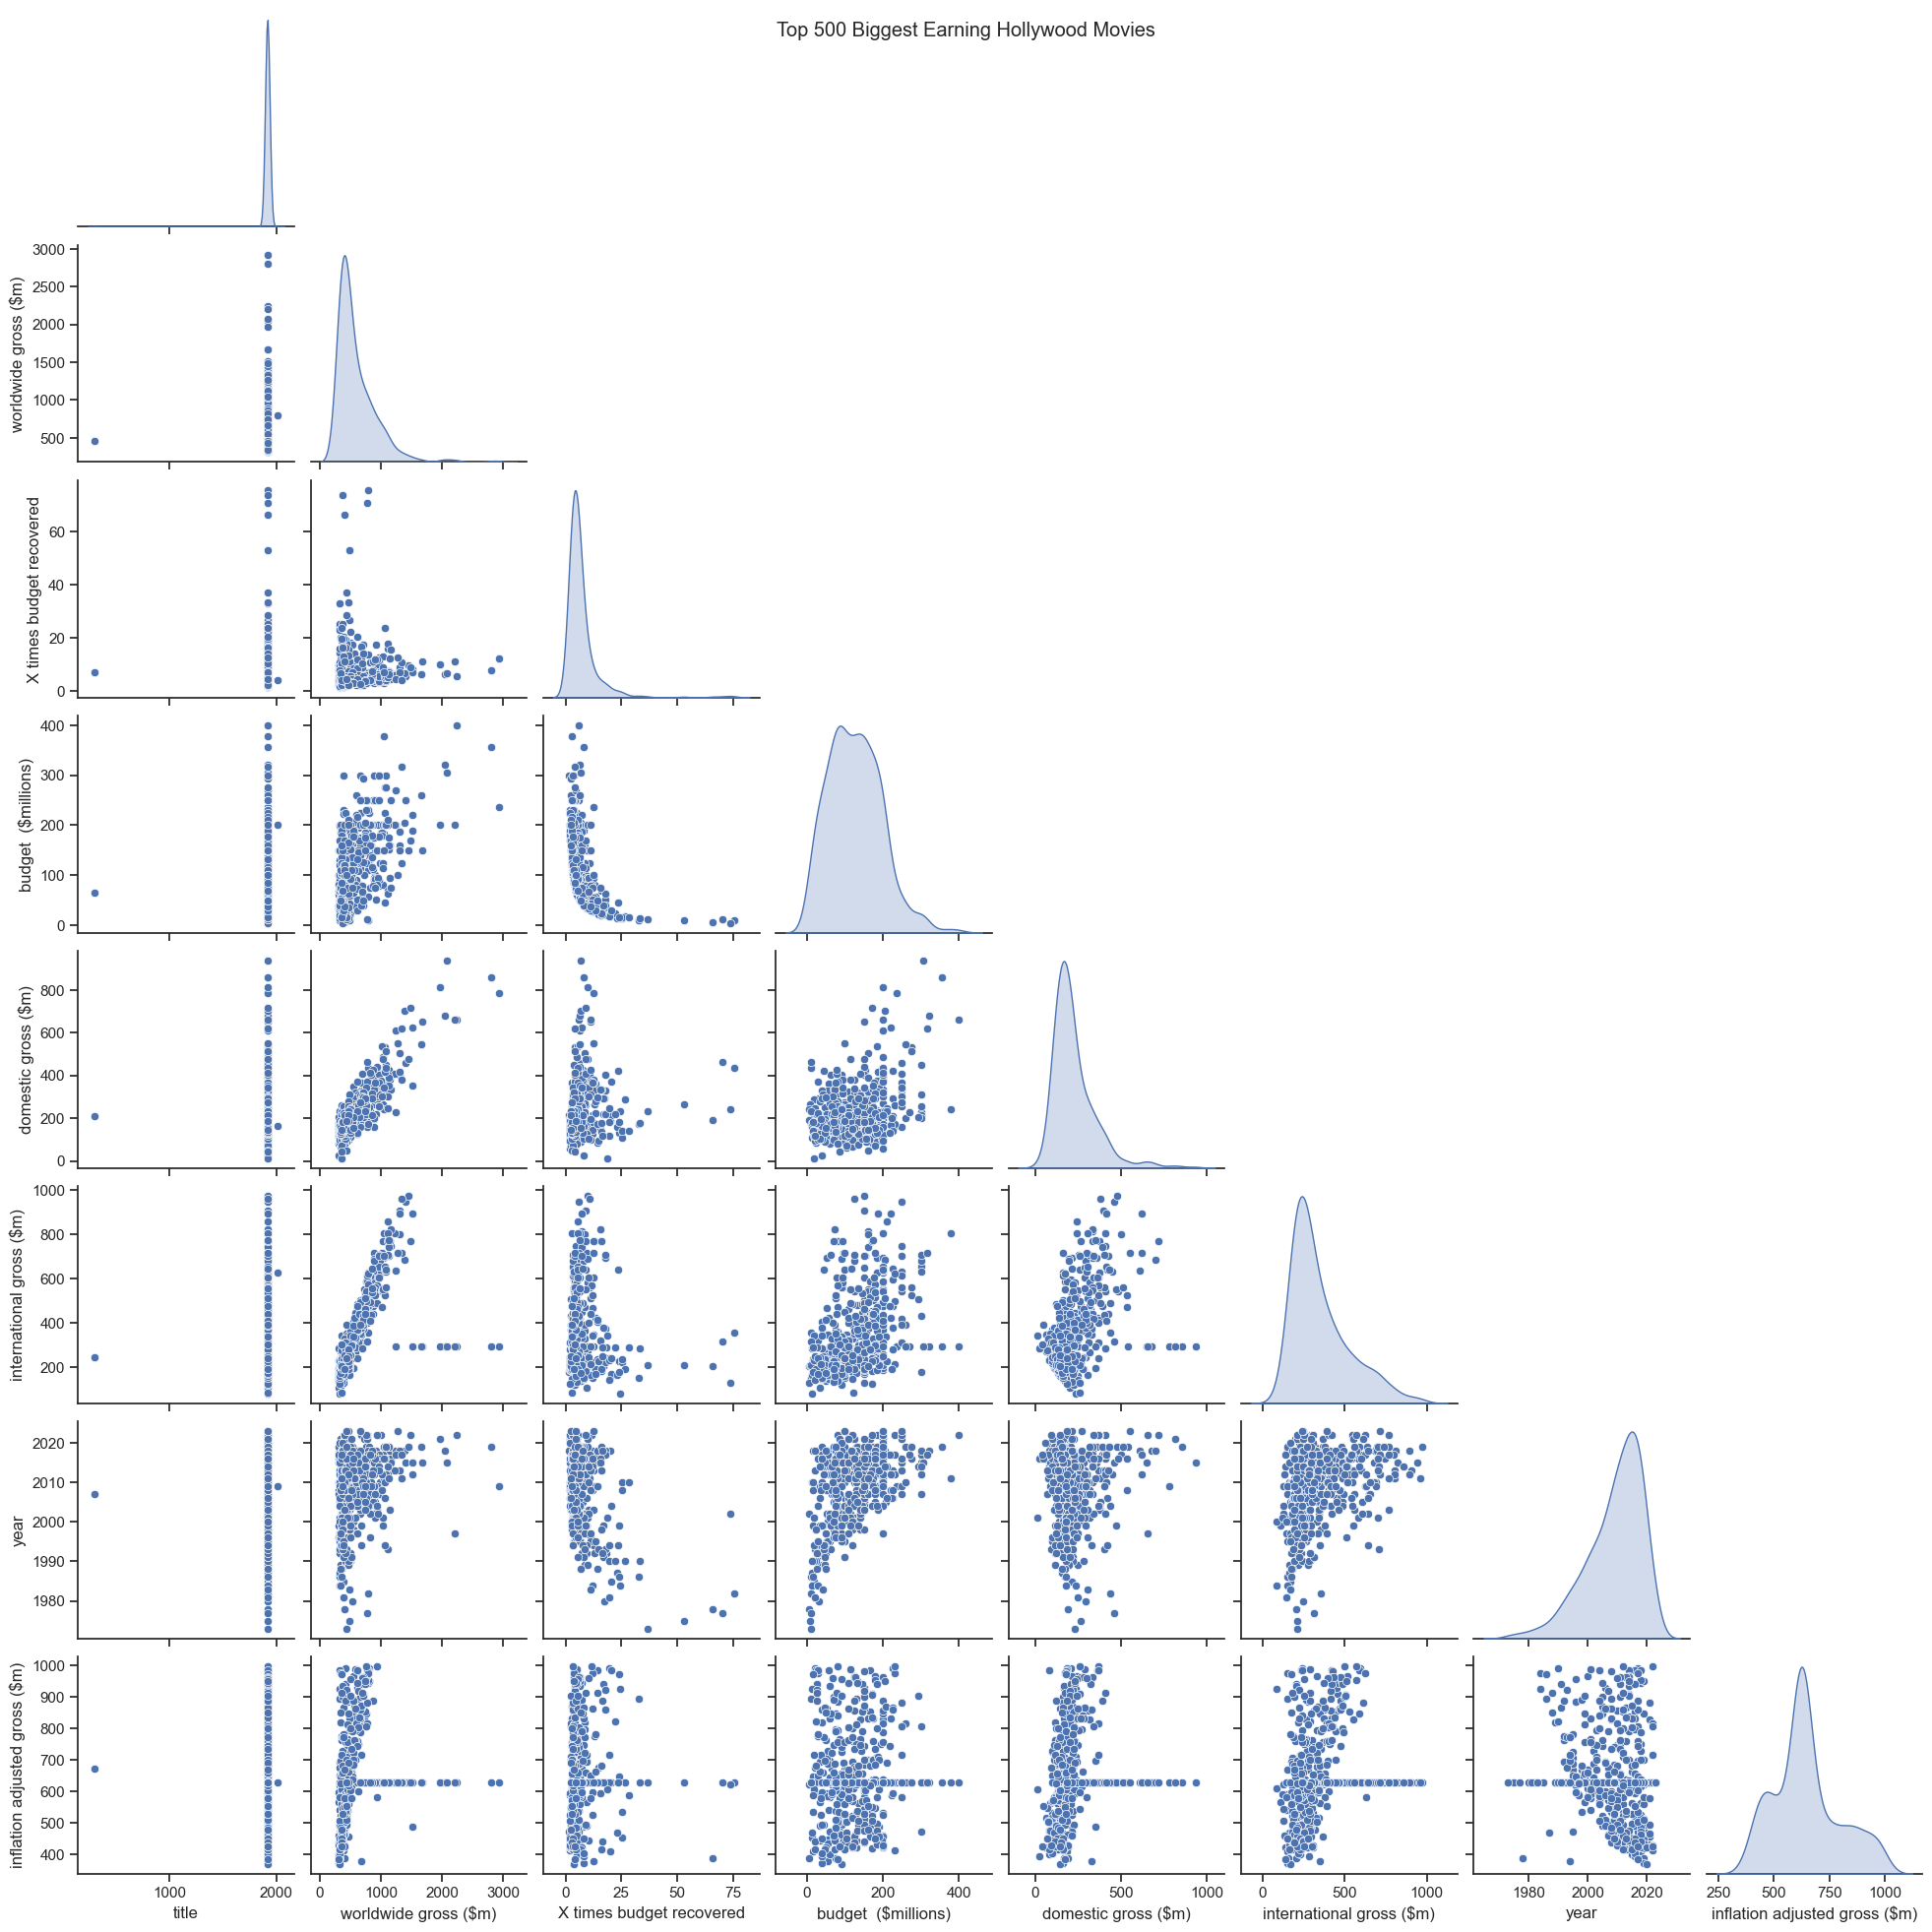

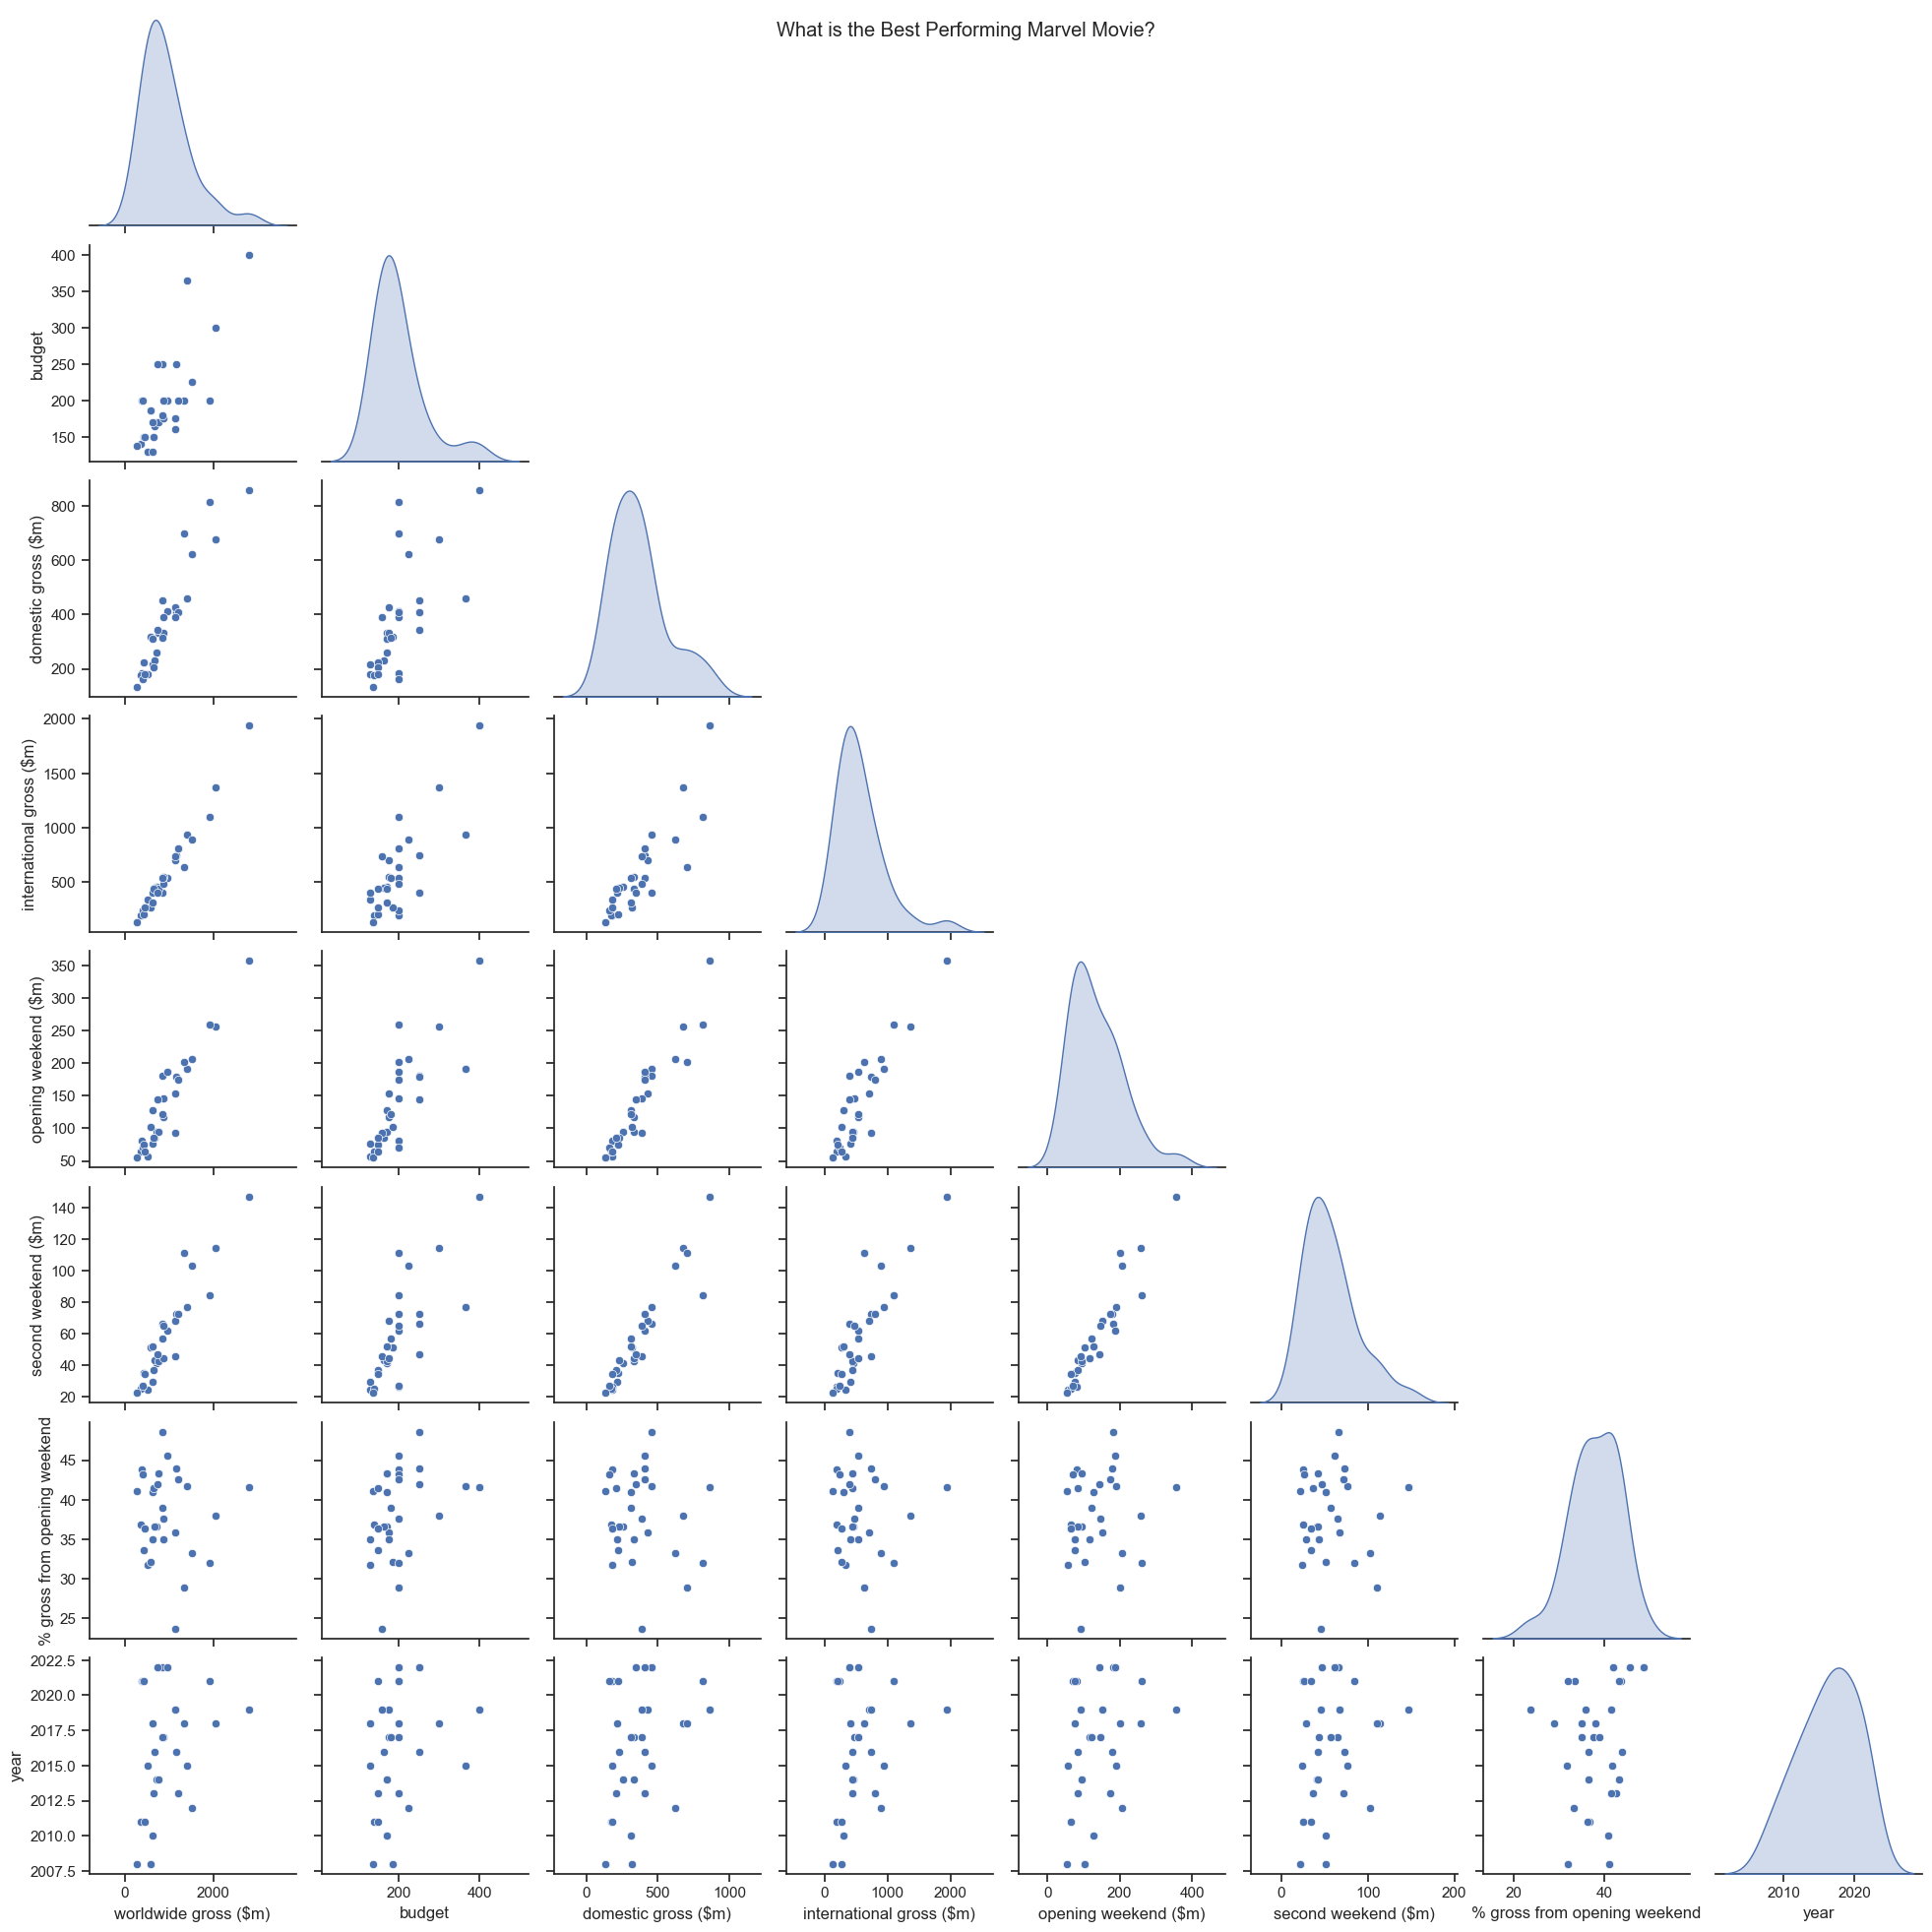

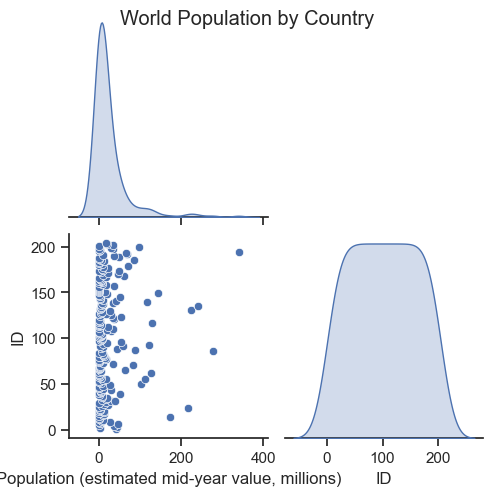

Not enough columns/rows to plot for dataset: The Emergence of AI powered LLMs and their Chatbots
Not enough columns/rows to plot for dataset: Where Does All The Plastic Go?
Not enough columns/rows to plot for dataset: Most Beautiful News of the Year 2023
Not enough columns/rows to plot for dataset: Best Novels of the Year 2023


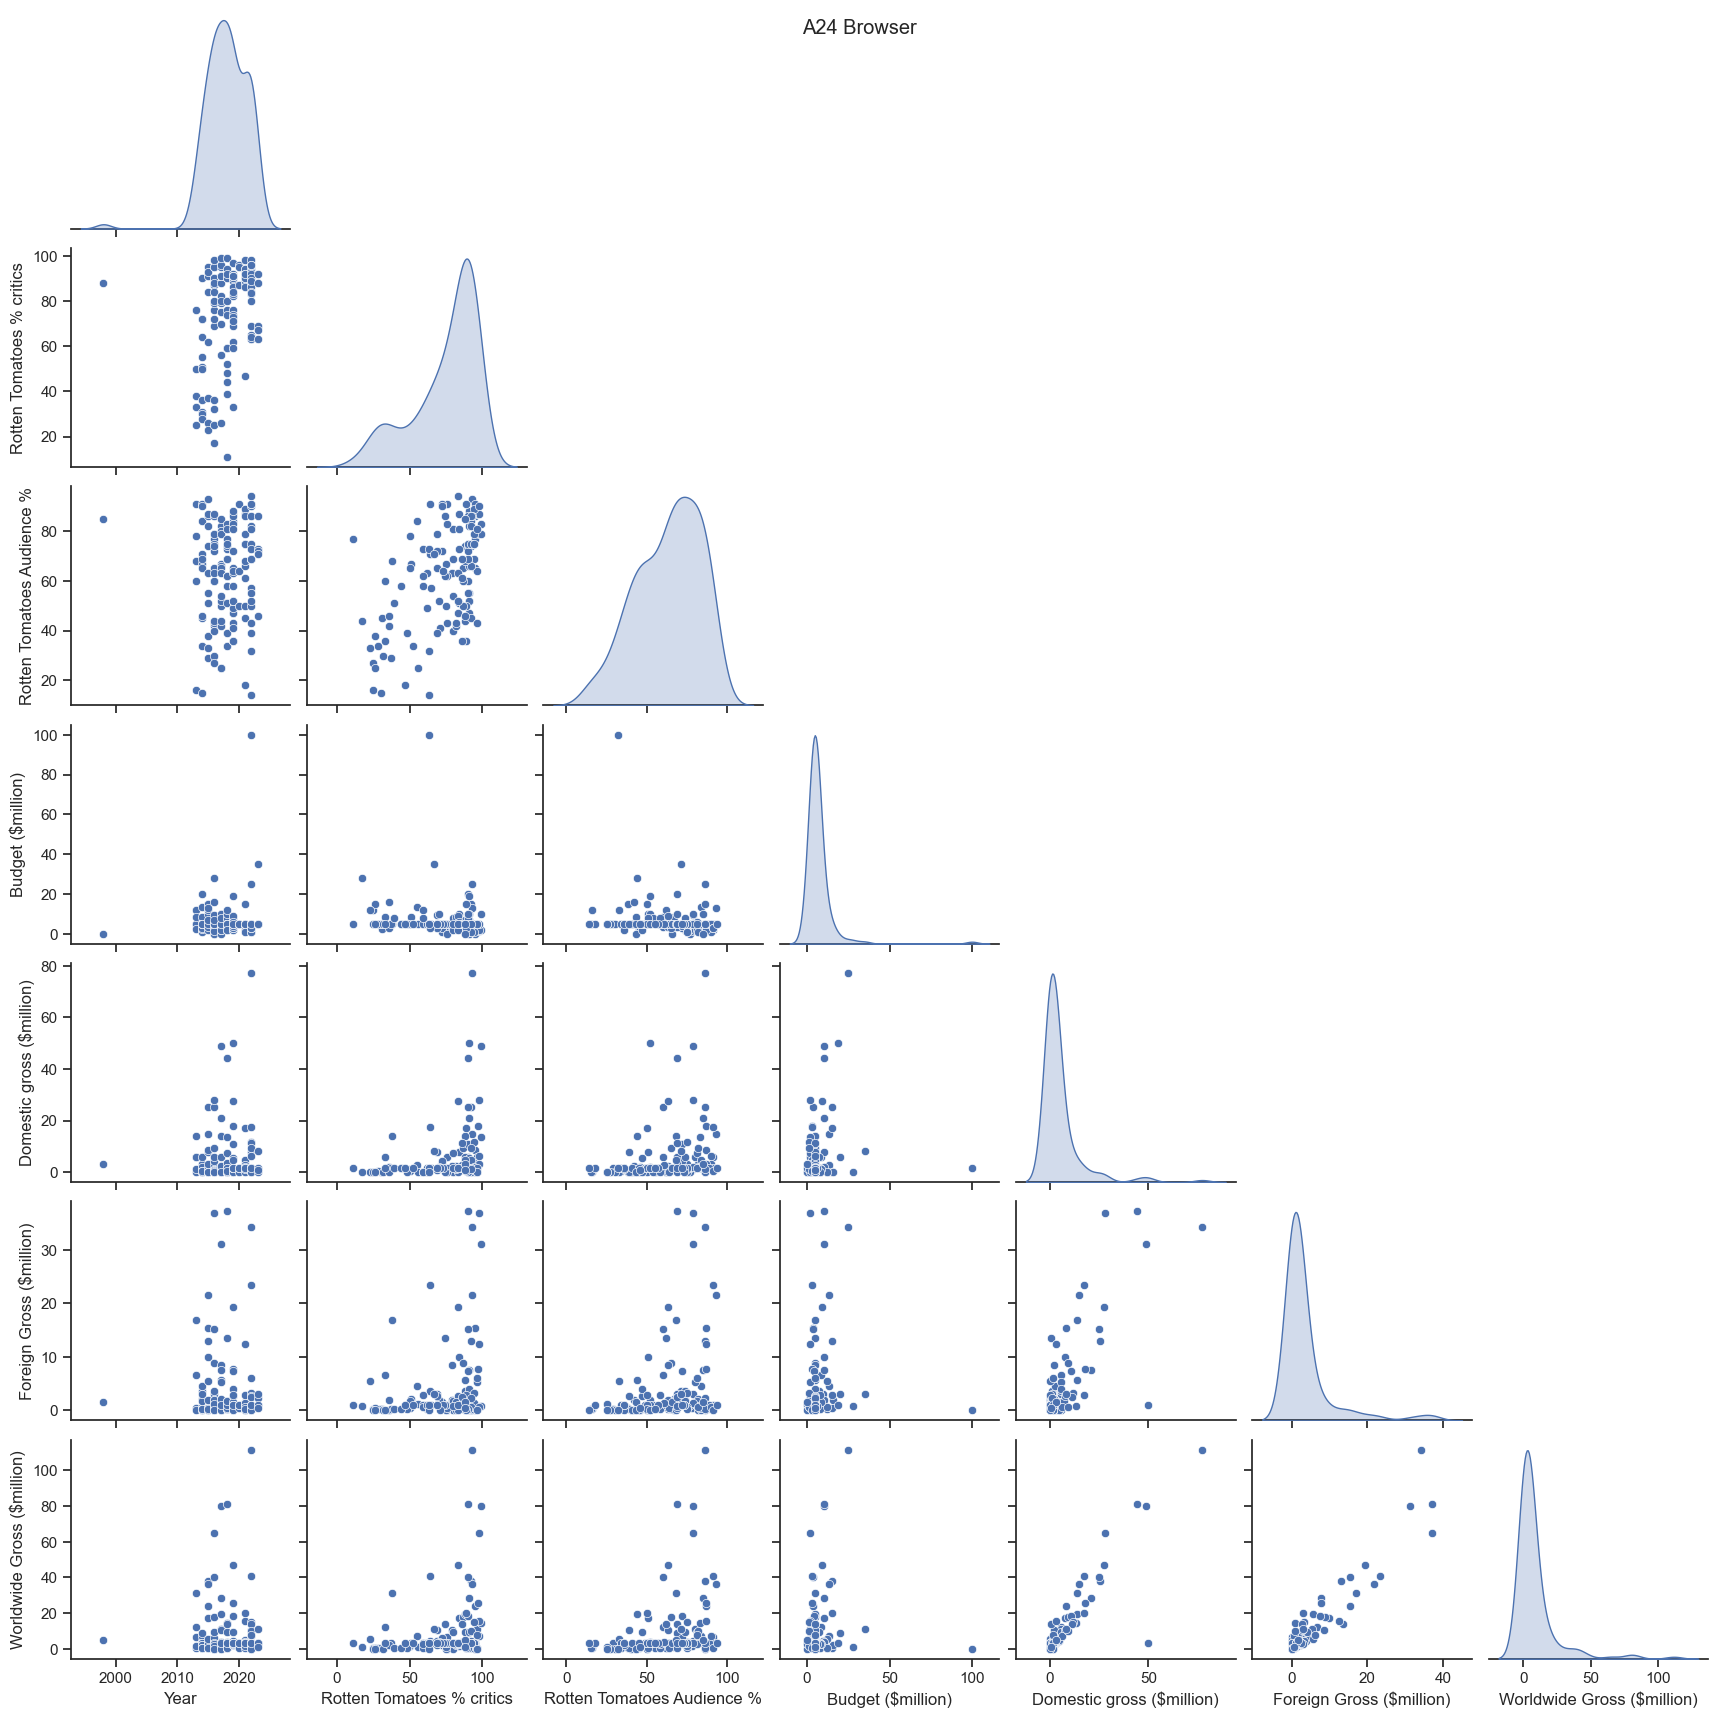

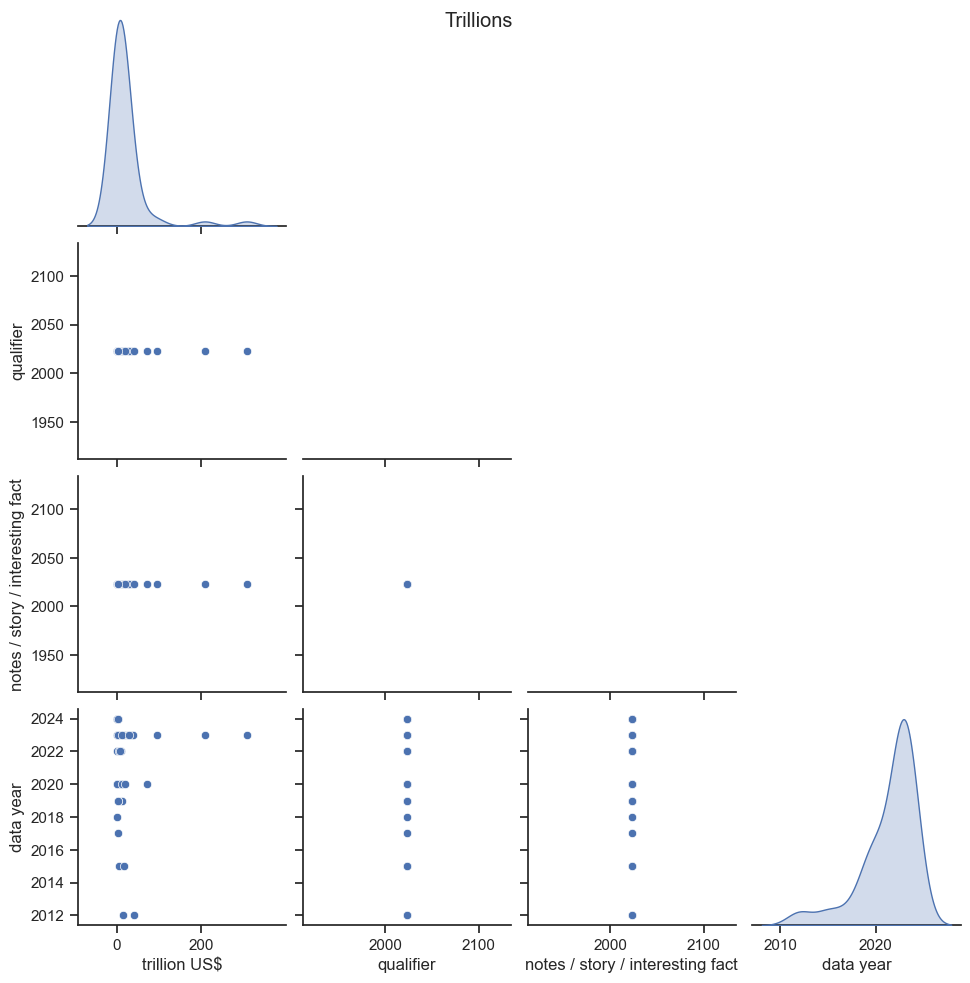

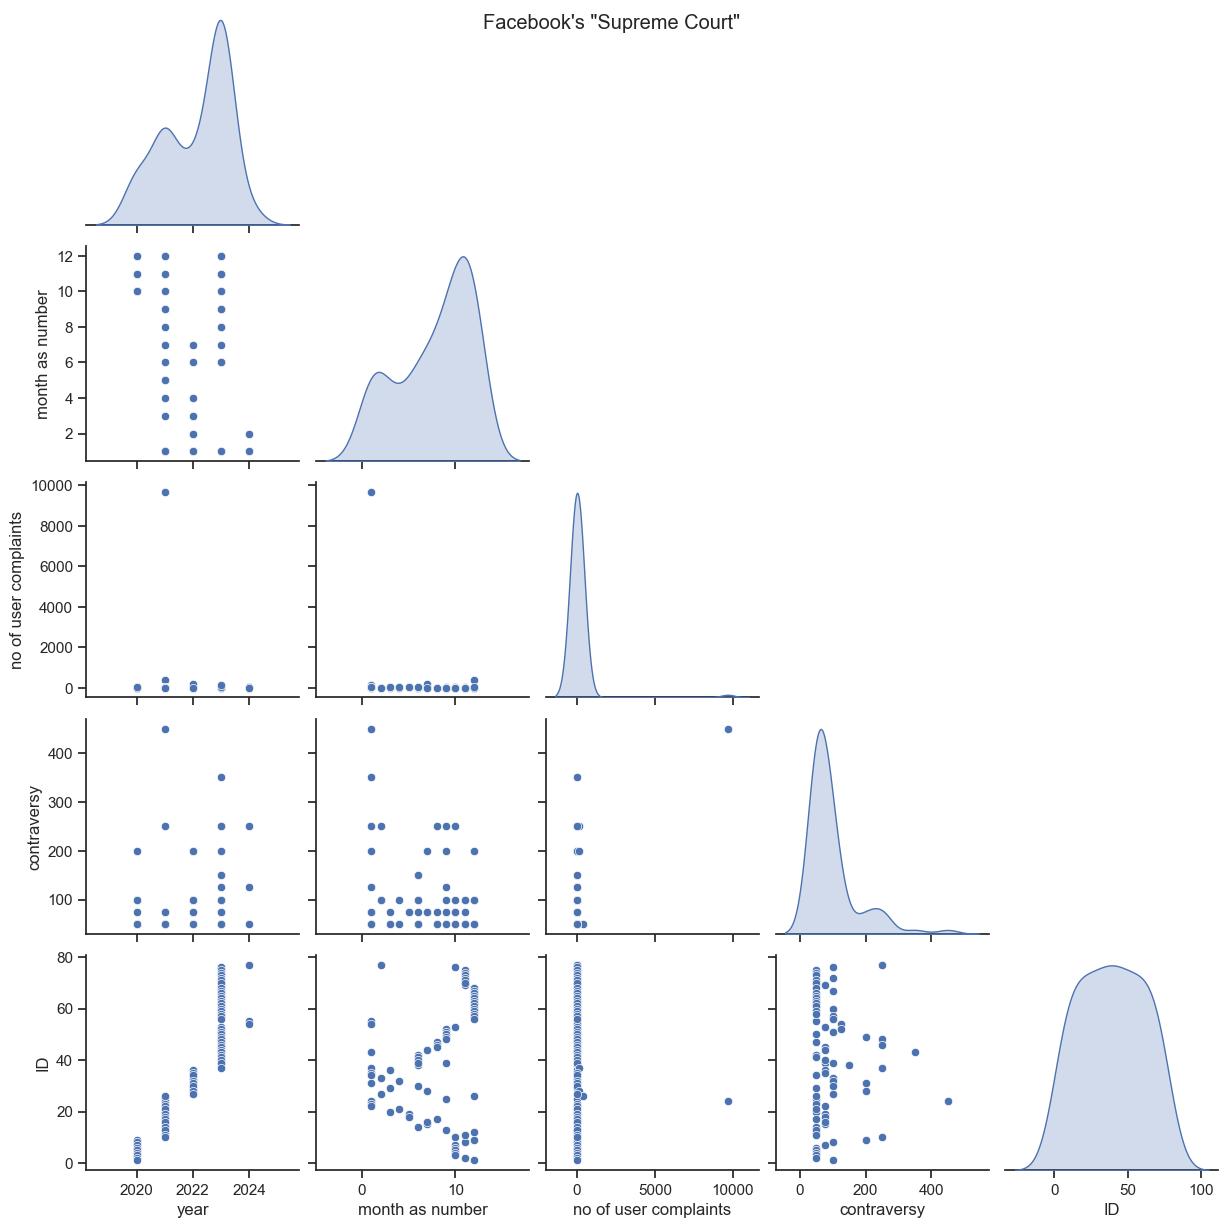

Not enough columns/rows to plot for dataset: Two Years of the Russia-Ukraine War
Not enough columns/rows to plot for dataset: Per Second
Not enough columns/rows to plot for dataset: WaterWorld
Not enough columns/rows to plot for dataset: Plastics - Problem with Recycling
Not enough columns/rows to plot for dataset: Plastics - 7 Types
Not enough columns/rows to plot for dataset: Plastics - Microplastics & Biodegradeability
Not enough columns/rows to plot for dataset: Plastics - BioPlastics
Not enough columns/rows to plot for dataset: Plastics - Solving the Plastics Crisis
Not enough columns/rows to plot for dataset: Plastics - Everyday actions


In [10]:
def plot_relationships(title: str, data: pd.DataFrame):
    """Plot relationships between columns in the dataset."""
    # Drop columns that start with 'Unnamed'
    to_plot = data.loc[:, ~data.columns.str.startswith('Unnamed')]
    
    # Check if there are at least two columns left to plot
    if to_plot.shape[1] < 2 or to_plot.shape[0] < 20:
        print(f"Not enough columns/rows to plot for dataset: {title}")
        return
    
    try:
        sns.set(style='ticks')
        sns.pairplot(to_plot, corner=True, diag_kind='kde', kind='scatter')

        plt.suptitle(title.replace("$", "\\$"))
        plt.show()
    except Exception as e:
        print(f"{title} error occurred: {e}")

for idx, dataset in enumerate(multi_datasets):
    """ Plot relationships between columns in each dataset """
    # print(f"Dataset {idx}: {dataset['title']}", end='\n')
    plot_relationships(dataset['title'], dataset['entry'])
    # break

### Feature Selection

Perform feature selection to improve model accuracy/ boost model's performance on higher dimension datasets

#### Remove features with low variance 
If the points are close to each other, they can be approximated as a singular point

In [11]:
from sklearn.feature_selection import VarianceThreshold

treated = []

In [12]:
def remove_low_varaince_points(data:pd.DataFrame)->pd.DataFrame:
    """Remove low variance points in the dataset."""
    if data.shape[1] < 10:
        return data
    
    # Check if there are numerical columns
    if data.select_dtypes(include=[np.number]).shape[1] == 0:
        return data
    
    selector = VarianceThreshold() # *By default, it removes features with zero variance
    selector.fit_transform(data.select_dtypes(include=[np.number])) # Fit to data, then transform it

    return data[data.columns[selector.get_support(indices=True)]] # Get the columns that have high variance

for idx, dataset in enumerate(multi_datasets):
    if dataset['title'] in treated:
        print(f"{dataset['title']} has already been treated.")
    else:
        treated.append(dataset['title'])
        print(f'{dataset['title']} \n\tbefore: {dataset["entry"].shape}', end=' ')
        dataset['entry'] = remove_low_varaince_points(dataset['entry'])
        print(f'After: {dataset["entry"].shape}')

Can Drugs Make You Happy? 
	before: (194, 9) After: (194, 9)
Reduce Your Odds Of Dying In A Plane Crash 
	before: (3, 0) After: (3, 0)
How I Learned To Stop Worrying And Love The Bomb 
	before: (13, 9) After: (13, 9)
Afghanistan Troop Casualties 
	before: (17, 13) After: (17, 4)
Caffeine and Calories 
	before: (29, 10) After: (29, 7)
Billion Dollar-o-Gram 
	before: (45, 2) After: (45, 2)
Timelines: Time Travel In Popular Film And TV 
	before: (52, 3) After: (52, 3)
Swine Flu Visualised 
	before: (124, 8) After: (124, 8)
Fatal Infection 
	before: (26, 14) After: (26, 14)
Kyoto: Who's On Target 
	before: (33, 2) After: (33, 2)
Who Rules The Social Web 
	before: (29, 5) After: (29, 5)
2012: The End Of The World? 
	before: (1, 1) After: (1, 1)
Afghanistan: The Information Is Not Beautiful 
	before: (17, 13) After: (17, 4)
Climate Change: A Consensus Among Scientists? 
	before: (14, 0) After: (14, 0)
What Does China Censor Online 
	before: (5, 2) After: (5, 2)
Haiti Earthquake: Who's Given 

#### Select features using Sequential Feature Selection
- SFS is a greedy procedure where by at each iteration, it chooses the best new feature to add to selected features based on a cross-validation score until the desired number of selected features.   
- It is a greedy search algorithm that selects features by adding or removing one feature at a time based on the classifier performance
- _SFS can be backwards or forwards_

In [13]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SequentialFeatureSelector 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, KFold

forwarded = []


In [14]:
fwrd_data = multi_datasets.copy()

In [15]:
def forward_SFS(data: pd.DataFrame) -> pd.DataFrame:
    """Select features using forward sequential selection."""
    """ TODO:
        - Identify categorical columns
        - Encode categorical columns into numerical features
        - Fit the feature selector with RandomForestRegressor
        - Return the selected features
    """
    categorical_columns = data.select_dtypes(exclude=['number']).columns
    data_to_forward = data.copy()

    if categorical_columns.size > 0:
        encoder = OrdinalEncoder()
        data_to_forward[categorical_columns] = encoder.fit_transform(data_to_forward[categorical_columns])

    # Initialize the cross-validation
    cv = KFold(n_splits=max(2,
                            (data_to_forward.shape[1])//2), 
               shuffle=True, 
               random_state=42)

    # Initialize the feature selector
    # print(f'\t\t num features .. {data_to_forward.shape[1]} features to select... {max(2, data_to_forward.shape[1]//3)}', 
    #       end=' ')
    feature_selector = SequentialFeatureSelector(RandomForestRegressor(), 
                                                 n_features_to_select=max(1, 
                                                                          min(data_to_forward.shape[1] - 1, 
                                                                              data_to_forward.shape[1] // 2)),
                                                 direction='forward',
                                                 cv = cv
                                                                          )
    
    if data_to_forward.shape[1] < 3:
        return data_to_forward
    
    # Fit the feature selector
    feature_selector.fit(data_to_forward.iloc[:, :-1], # Get all columns except the target column
                         data_to_forward.iloc[:, -1] # Get the target column
                        )
    # Get the selected features
    selected_features = data_to_forward.iloc[:, feature_selector.get_support(indices=True)]

    return selected_features
    
for idx, dataset in enumerate(fwrd_data):
    """ Select features using forward sequential selection """
    if dataset['title'] in forwarded:
        # print(f"{dataset['title']} has already been forwarded.")
        continue
    else:
        rows, columns = dataset['entry'].shape[0], dataset['entry'].shape[1]
        
        if columns > 2 or rows > 10:
            print(f"Dataset {idx}: {dataset['title']} with {dataset['entry'].shape} ", end='\t')
            dataset['entry'] = forward_SFS(dataset['entry'])
            print(f"after: {dataset['entry'].shape} ")

        forwarded.append(dataset['title'])
    

Dataset 0: Can Drugs Make You Happy? with (194, 9) 	after: (194, 4) 
Dataset 2: How I Learned To Stop Worrying And Love The Bomb with (13, 9) 	after: (13, 4) 
Dataset 3: Afghanistan Troop Casualties with (17, 4) 	after: (17, 2) 
Dataset 4: Caffeine and Calories with (29, 7) 	after: (29, 3) 
Dataset 5: Billion Dollar-o-Gram with (45, 2) 	after: (45, 2) 
Dataset 6: Timelines: Time Travel In Popular Film And TV with (52, 3) 	after: (52, 1) 
Dataset 7: Swine Flu Visualised with (124, 8) 	after: (124, 4) 
Dataset 8: Fatal Infection with (26, 14) 	after: (26, 7) 
Dataset 9: Kyoto: Who's On Target with (33, 2) 	after: (33, 2) 
Dataset 10: Who Rules The Social Web with (29, 5) 	after: (29, 2) 
Dataset 12: Afghanistan: The Information Is Not Beautiful with (17, 4) 	after: (17, 2) 
Dataset 13: Climate Change: A Consensus Among Scientists? with (14, 0) 	after: (14, 0) 
Dataset 15: Haiti Earthquake: Who's Given What? with (35, 9) 	after: (35, 4) 
Dataset 16: When Sea Levels Attack with (52, 7) 	af

## Recommendations for Preprocessing
How can the data be preprocesssed?